# Wearable Watch Dataset

The data used in this project is that of apple watch and fitbit data of 46 participants.

https://www.kaggle.com/datasets/aleespinosa/apple-watch-and-fitbit-data/data

## 1. Importing the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import xgboost as xgb

from scipy import stats
from scipy.stats import zscore, uniform, randint

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
data = pd.read_csv('data/dataverse_files/aw_fb_data.csv',index_col = 0)
data.head()

X1  age  gender  height  weight      steps  hear_rate   calories  distance  \
1   1   20       1   168.0    65.4  10.771429  78.531302   0.344533  0.008327   
2   2   20       1   168.0    65.4  11.475325  78.453390   3.287625  0.008896   
3   3   20       1   168.0    65.4  12.179221  78.540825   9.484000  0.009466   
4   4   20       1   168.0    65.4  12.883117  78.628260  10.154556  0.010035   
5   5   20       1   168.0    65.4  13.587013  78.715695  10.825111  0.010605   

   entropy_heart  entropy_setps  resting_heart  corr_heart_steps  norm_heart  \
1       6.221612       6.116349           59.0          1.000000   19.531302   
2       6.221612       6.116349           59.0          1.000000   19.453390   
3       6.221612       6.116349           59.0          1.000000   19.540825   
4       6.221612       6.116349           59.0          1.000000   19.628260   
5       6.221612       6.116349           59.0          0.982816   19.715695   

   intensity_karvonen  sd_norm_heart  steps_times_distance       device  \
1            0.138520       1.000000              0.089692  apple watch   
2            0.137967       1.000000              0.102088  apple watch   
3            0.138587       1.000000              0.115287  apple watch   
4            0.139208       1.000000              0.129286  apple watch   
5            0.139828       0.241567              0.144088  apple watch   

  activity  
1    Lying  
2    Lying  
3    Lying  
4    Lying  
5    Lying

## 2. Data Cleaning

In [3]:
data.columns

Index(['X1', 'age', 'gender', 'height', 'weight', 'steps', 'hear_rate',
       'calories', 'distance', 'entropy_heart', 'entropy_setps',
       'resting_heart', 'corr_heart_steps', 'norm_heart', 'intensity_karvonen',
       'sd_norm_heart', 'steps_times_distance', 'device', 'activity'],
      dtype='object')

In [4]:
data.shape

(6264, 19)

Correcting the spelling of `heart_rate` and `entropy_steps`:

In [5]:
data.columns = ['X1', 'age', 'gender', 'height', 'weight', 'steps', 'heart_rate',
       'calories', 'distance', 'entropy_heart', 'entropy_steps',
       'resting_heart', 'corr_heart_steps', 'norm_heart', 'intensity_karvonen',
       'sd_norm_heart', 'steps_times_distance', 'device', 'activity']

data.columns

Index(['X1', 'age', 'gender', 'height', 'weight', 'steps', 'heart_rate',
       'calories', 'distance', 'entropy_heart', 'entropy_steps',
       'resting_heart', 'corr_heart_steps', 'norm_heart', 'intensity_karvonen',
       'sd_norm_heart', 'steps_times_distance', 'device', 'activity'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6264 entries, 1 to 6264
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   X1                    6264 non-null   int64  
 1   age                   6264 non-null   int64  
 2   gender                6264 non-null   int64  
 3   height                6264 non-null   float64
 4   weight                6264 non-null   float64
 5   steps                 6264 non-null   float64
 6   heart_rate            6264 non-null   float64
 7   calories              6264 non-null   float64
 8   distance              6264 non-null   float64
 9   entropy_heart         6264 non-null   float64
 10  entropy_steps         6264 non-null   float64
 11  resting_heart         6264 non-null   float64
 12  corr_heart_steps      6264 non-null   float64
 13  norm_heart            6264 non-null   float64
 14  intensity_karvonen    6264 non-null   float64
 15  sd_norm_heart         6264

In [7]:
null_counts = data.isnull().sum()
null_counts

X1                      0
age                     0
gender                  0
height                  0
weight                  0
steps                   0
heart_rate              0
calories                0
distance                0
entropy_heart           0
entropy_steps           0
resting_heart           0
corr_heart_steps        0
norm_heart              0
intensity_karvonen      0
sd_norm_heart           0
steps_times_distance    0
device                  0
activity                0
dtype: int64

In [8]:
data.duplicated().sum()

0

In [9]:
data.describe()

X1          age       gender       height       weight  \
count  6264.000000  6264.000000  6264.000000  6264.000000  6264.000000   
mean   1771.144317    29.158525     0.476533   169.709052    69.614464   
std    1097.988748     8.908978     0.499489    10.324698    13.451878   
min       1.000000    18.000000     0.000000   143.000000    43.000000   
25%     789.750000    23.000000     0.000000   160.000000    60.000000   
50%    1720.000000    28.000000     0.000000   168.000000    68.000000   
75%    2759.250000    33.000000     1.000000   180.000000    77.300000   
max    3670.000000    56.000000     1.000000   191.000000   115.000000   

             steps   heart_rate     calories     distance  entropy_heart  \
count  6264.000000  6264.000000  6264.000000  6264.000000    6264.000000   
mean    109.562268    86.142331    19.471823    13.832555       6.030314   
std     222.797908    28.648385    27.309765    45.941437       0.765574   
min       1.000000     2.222222     0.056269     0.000440       0.000000   
25%       5.159534    75.598079     0.735875     0.019135       6.108524   
50%      10.092029    77.267680     4.000000     0.181719       6.189825   
75%     105.847222    95.669118    20.500000    15.697188       6.247928   
max    1714.000000   194.333333    97.500000   335.000000       6.475733   

       entropy_steps  resting_heart  corr_heart_steps   norm_heart  \
count    6264.000000    6264.000000       6264.000000  6264.000000   
mean        5.739984      65.869938          0.306447    20.272393   
std         1.256348      21.203017          0.775418    28.388116   
min         0.000000       3.000000         -1.000000   -76.000000   
25%         5.909440      58.134333         -0.467303     1.148883   
50%         6.157197      75.000000          0.665829     9.820254   
75%         6.247928      76.138701          1.000000    27.077336   
max         6.475733     155.000000          1.000000   156.319444   

       intensity_karvonen  sd_norm_heart  steps_times_distance  
count         6264.000000    6264.000000           6264.000000  
mean             0.155479       8.110854            590.035239  
std              0.210927      12.535080           4063.838530  
min             -2.714286       0.000000              0.000690  
25%              0.009819       0.264722              0.659260  
50%              0.079529       2.893503             13.368619  
75%              0.211868       9.679672             93.728562  
max              1.297980      74.457929          51520.000000

In [10]:
counts = data.groupby(['activity']).size()
counts

activity
Lying             1379
Running 3 METs     950
Running 5 METs    1002
Running 7 METs    1114
Self Pace walk     889
Sitting            930
dtype: int64

In [11]:
data['activity'].unique()

array(['Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs'], dtype=object)

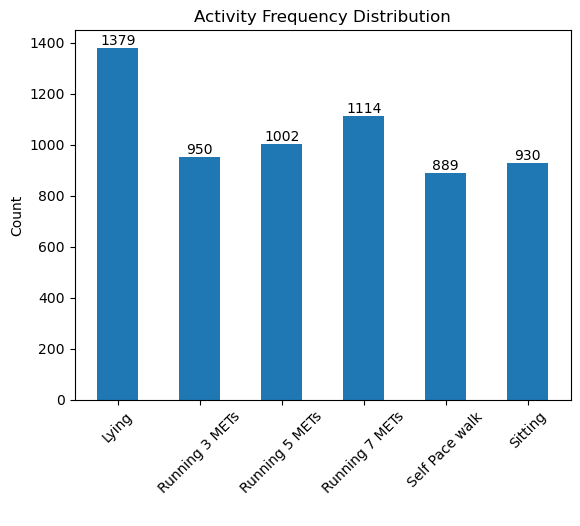

In [12]:
plt.figure()
barplot = plt.bar(counts.index, counts, width = 0.5)
plt.xlabel(' ')
plt.ylabel('Count')
plt.title('Activity Frequency Distribution')
plt.bar_label(barplot,labels = counts, label_type = "edge")
plt.xticks(rotation=45)
plt.show()

The activity (target variable) column is not in numerical format. Transforming that using label encoder:

In [13]:
label_encode=LabelEncoder()

In [14]:
le=label_encode.fit(data['activity'])
activity_data=le.transform(data['activity'])

In [15]:
le_name_mapping = dict(zip(le.transform(le.classes_),le.classes_))
print(le_name_mapping)

{0: 'Lying', 1: 'Running 3 METs', 2: 'Running 5 METs', 3: 'Running 7 METs', 4: 'Self Pace walk', 5: 'Sitting'}


In [16]:
data['activity_encoded']=activity_data
data.groupby(['activity_encoded']).size()

activity_encoded
0    1379
1     950
2    1002
3    1114
4     889
5     930
dtype: int64

In [17]:
data.head()

X1  age  gender  height  weight      steps  heart_rate   calories  \
1   1   20       1   168.0    65.4  10.771429   78.531302   0.344533   
2   2   20       1   168.0    65.4  11.475325   78.453390   3.287625   
3   3   20       1   168.0    65.4  12.179221   78.540825   9.484000   
4   4   20       1   168.0    65.4  12.883117   78.628260  10.154556   
5   5   20       1   168.0    65.4  13.587013   78.715695  10.825111   

   distance  entropy_heart  entropy_steps  resting_heart  corr_heart_steps  \
1  0.008327       6.221612       6.116349           59.0          1.000000   
2  0.008896       6.221612       6.116349           59.0          1.000000   
3  0.009466       6.221612       6.116349           59.0          1.000000   
4  0.010035       6.221612       6.116349           59.0          1.000000   
5  0.010605       6.221612       6.116349           59.0          0.982816   

   norm_heart  intensity_karvonen  sd_norm_heart  steps_times_distance  \
1   19.531302            0.138520       1.000000              0.089692   
2   19.453390            0.137967       1.000000              0.102088   
3   19.540825            0.138587       1.000000              0.115287   
4   19.628260            0.139208       1.000000              0.129286   
5   19.715695            0.139828       0.241567              0.144088   

        device activity  activity_encoded  
1  apple watch    Lying                 0  
2  apple watch    Lying                 0  
3  apple watch    Lying                 0  
4  apple watch    Lying                 0  
5  apple watch    Lying                 0

## 3. Exploratory Data Analysis (EDA)

In the dataset, the gender is represented with a 0 and 1. What each number represents (Male or Female) is unknown. To find that out the following analysis is performed:

In [18]:
data.groupby('gender').agg({
    'weight': ['mean', 'median', 'std'],
    'height': ['mean', 'median', 'std']
})

weight                        height                 
             mean median        std        mean median       std
gender                                                          
0       62.165233   60.5  10.480210  162.460781  163.0  7.059994
1       77.797387   76.7  11.453352  177.671223  180.0  6.916224

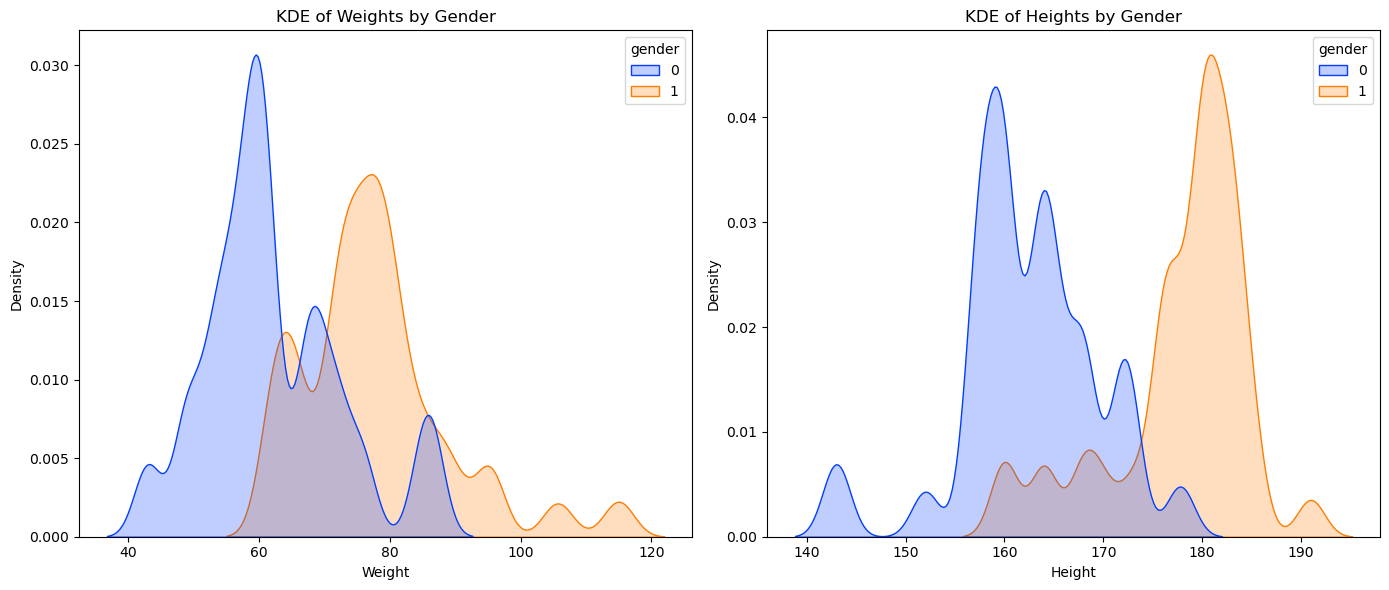

In [19]:
# Set the figure size
plt.figure(figsize=(14, 6))

# Plot the KDE(kernel density estimate) of weights grouped by gender
plt.subplot(1, 2, 1)
sns.kdeplot(data=data, x='weight', hue='gender', fill=True, palette='bright')
plt.title('KDE of Weights by Gender')
plt.xlabel('Weight')
plt.ylabel('Density')

# Plot the KDE of heights grouped by gender
plt.subplot(1, 2, 2)
sns.kdeplot(data=data, x='height', hue='gender', fill=True, palette='bright')
plt.title('KDE of Heights by Gender')
plt.xlabel('Height')
plt.ylabel('Density')

# Adjust layout
plt.tight_layout()
plt.show()

From the fact that weight and height of females is generally lower than males, we can observe that 0 is Female and 1 is Male.

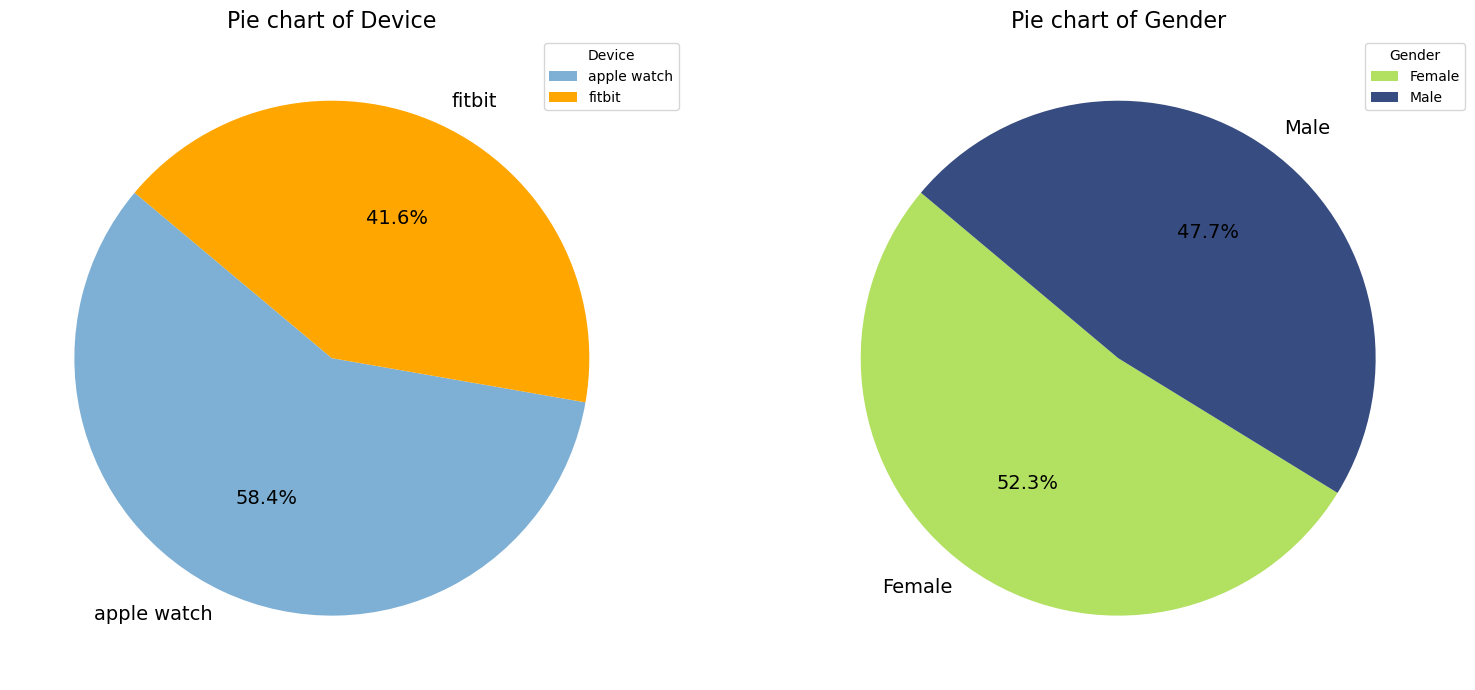

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot pie chart for 'device'
value_counts_device = data['device'].value_counts()
axes[0].pie(value_counts_device, labels=value_counts_device.index, autopct='%1.1f%%', startangle=140, colors=['#7eb0d5', '#ffa600'], textprops={'fontsize': 14})
axes[0].set_title('Pie chart of Device', fontsize=16)
axes[0].legend(title='Device', bbox_to_anchor=(1.05, 1), loc='best')

# Plot pie chart for 'gender'
value_counts_gender = data['gender'].value_counts()

gender_labels = ['Female', 'Male']
axes[1].pie(value_counts_gender, labels=gender_labels, autopct='%1.1f%%', startangle=140, colors=['#b2e061', '#374c80'], textprops={'fontsize': 14})
axes[1].set_title('Pie chart of Gender', fontsize=16)
axes[1].legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='best')


plt.tight_layout()
plt.show()

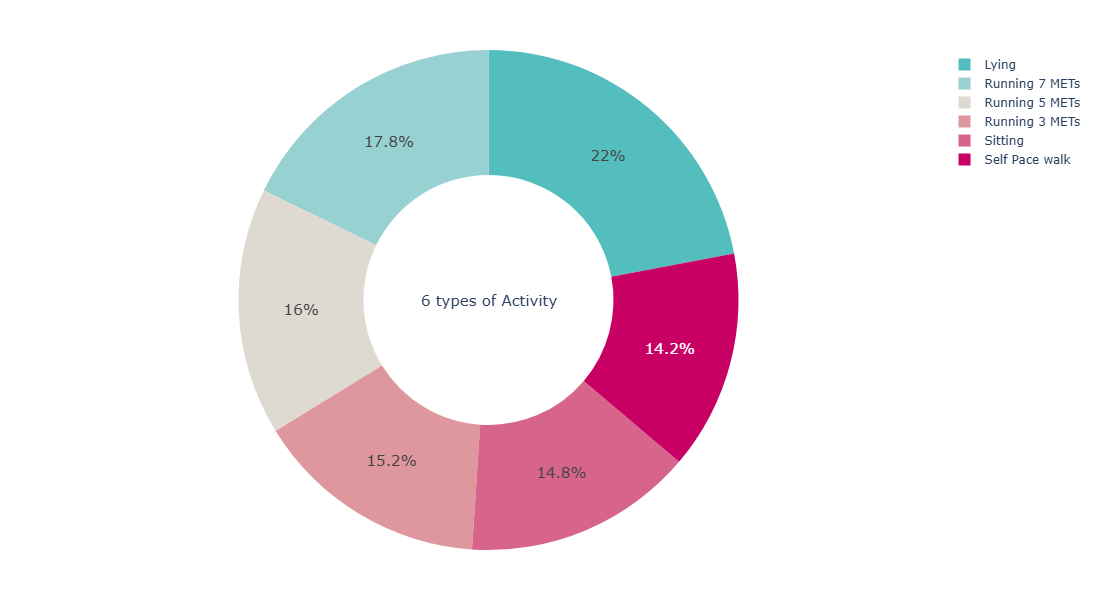

In [21]:
labels = ['Lying','Running 7 METs','Running 5 METs','Running 3 METs', 'Sitting', 'Self Pace walk']
values = data['activity'].value_counts()
colors = ['#54bebe', '#98d1d1','#dedad2','#df979e','#d7658b','#c80064']
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.5)])
fig.update_traces(hoverinfo='label+value',textfont_size=15,marker=dict(colors=colors))
fig.update_layout(
    annotations=[dict(text='6 types of Activity', x=0.50, y=0.5, font_size=15, showarrow=False)],
    margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins as needed
    height=600,  # Adjust height for better visualization
    width=600,   # Adjust width for better visualization
    showlegend=True
)
fig.show()

C:\Users\shriy\AppData\Local\Temp\ipykernel_10552\3262849815.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='age', ylabel='Density'>

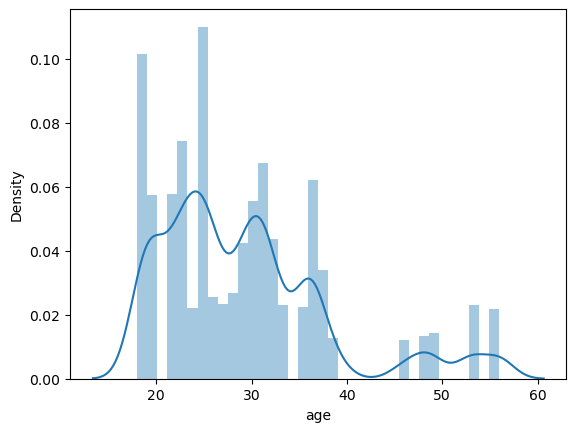

In [22]:
sns.distplot(data['age'])

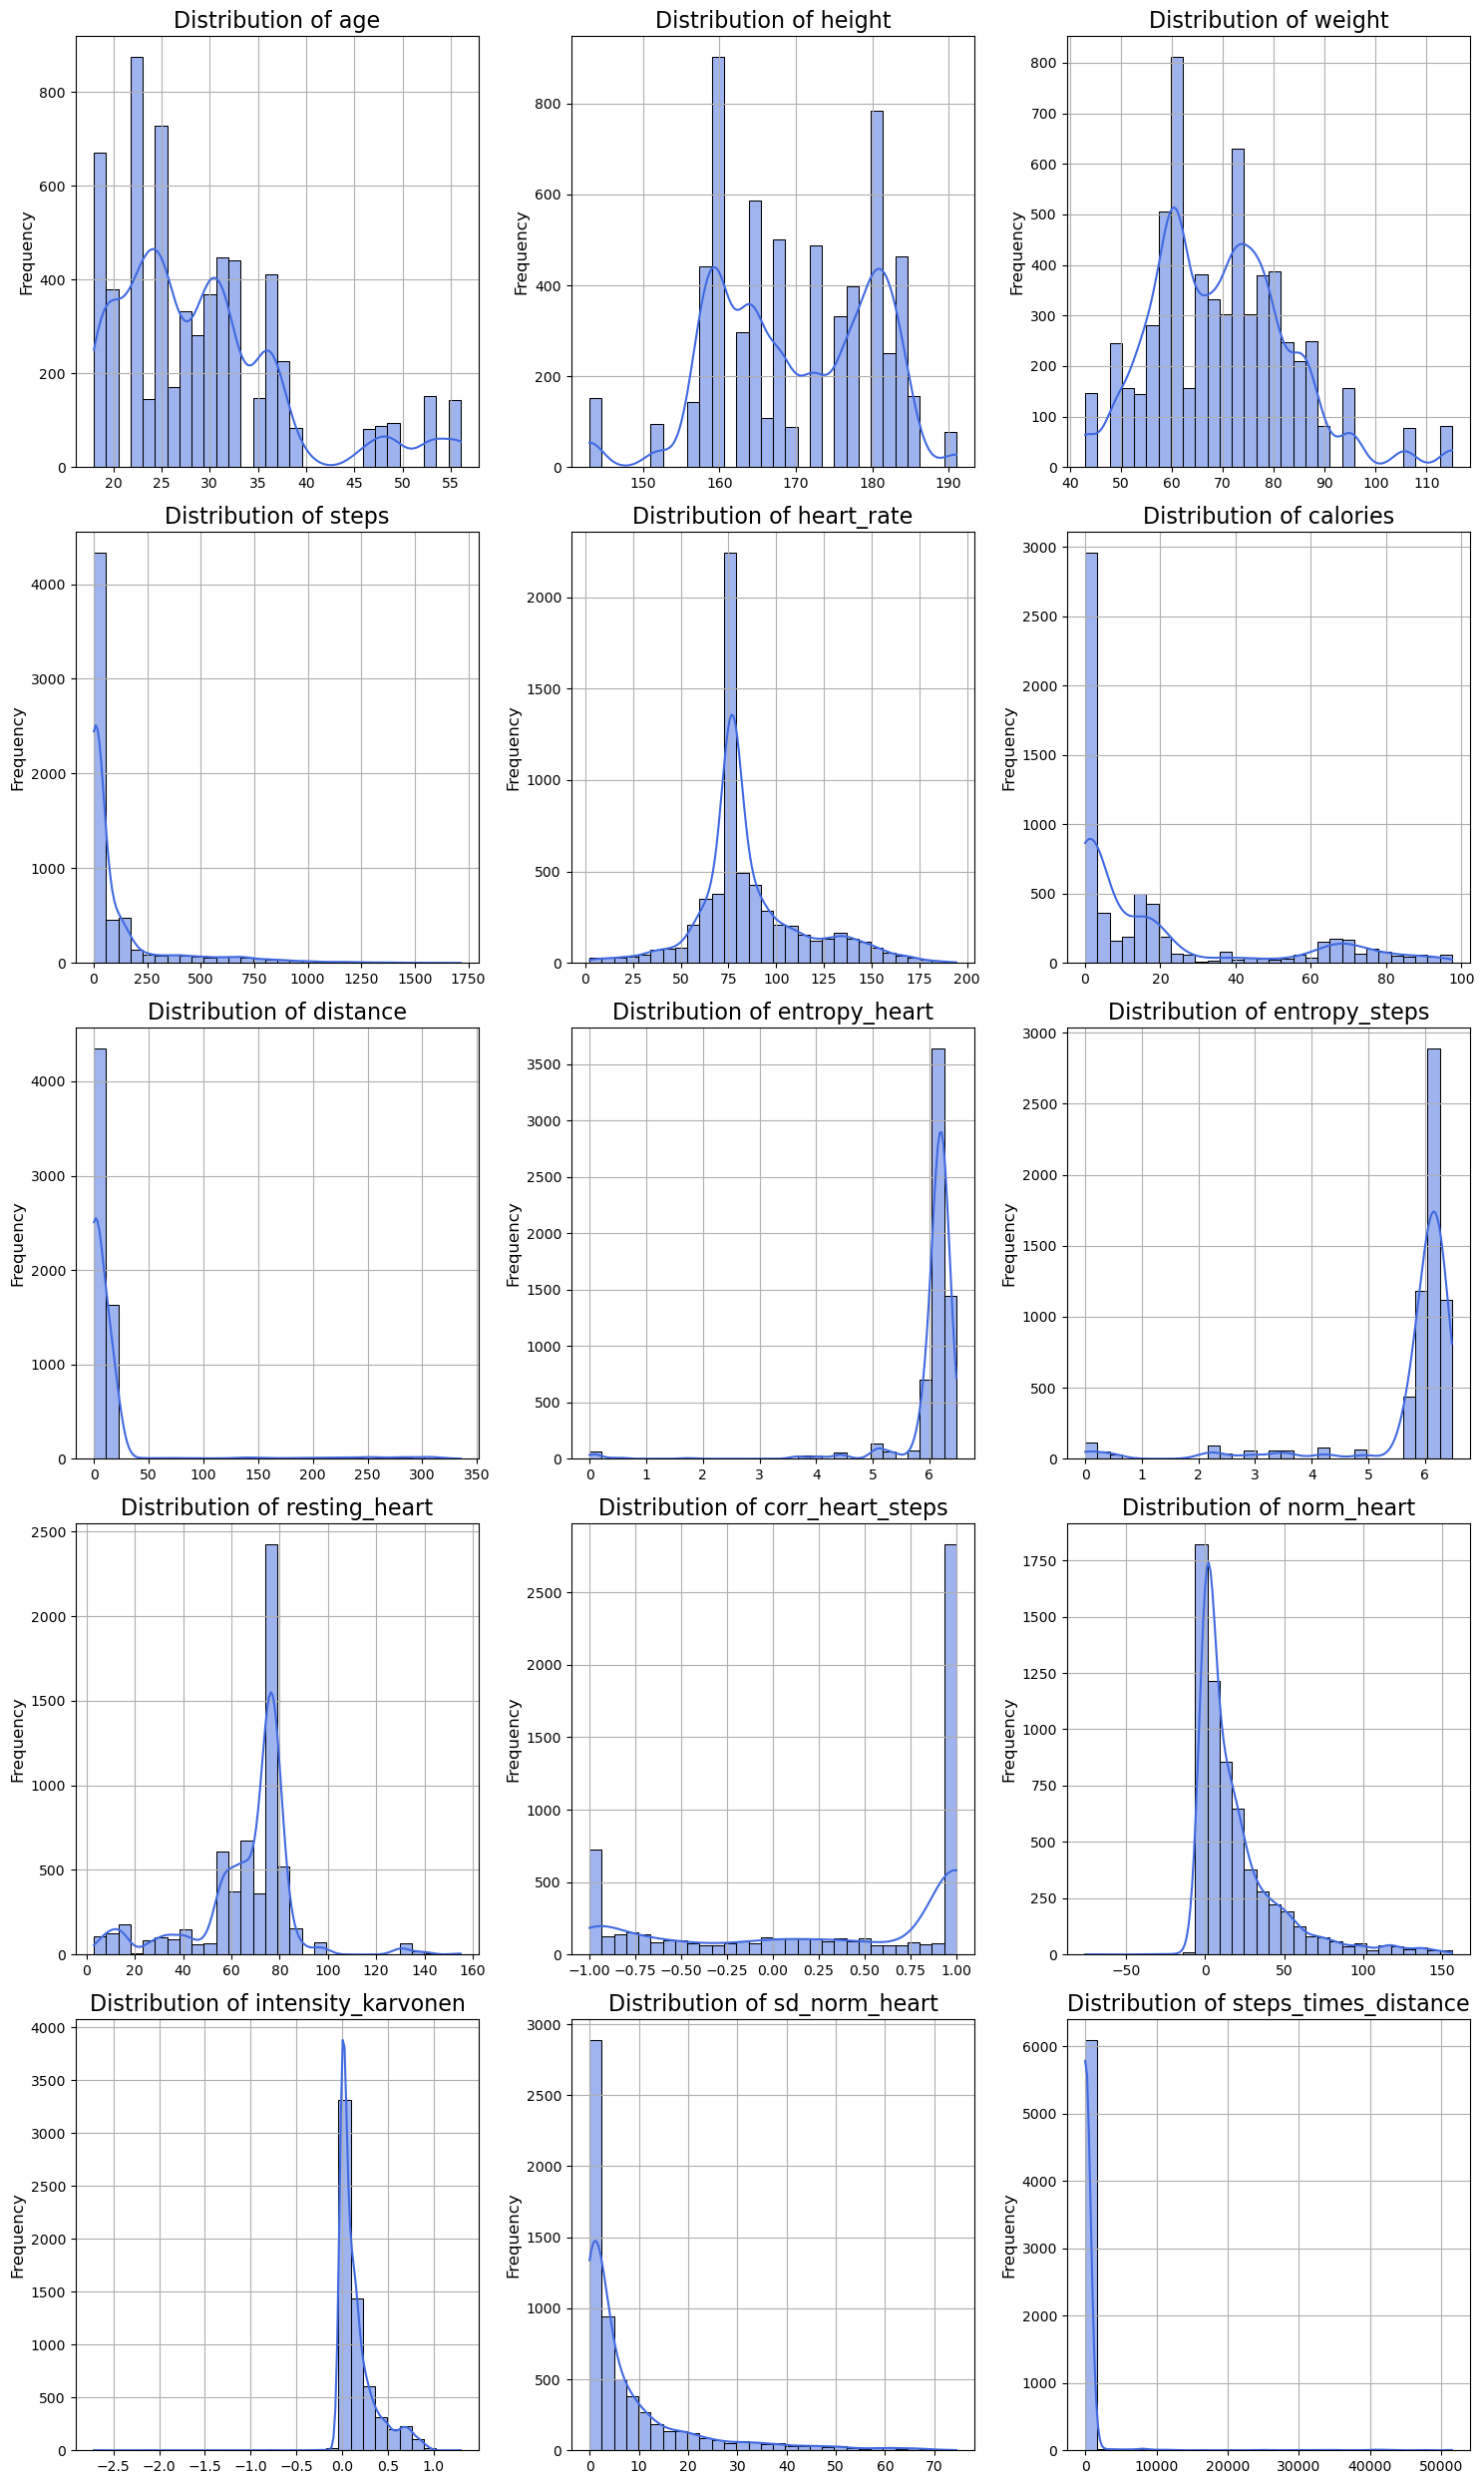

In [23]:
# List of numerical features
var = [
    'age', 'height', 'weight', 'steps', 'heart_rate', 'calories', 
    'distance', 'entropy_heart', 'entropy_steps', 'resting_heart', 
    'corr_heart_steps', 'norm_heart', 'intensity_karvonen', 'sd_norm_heart', 
    'steps_times_distance'
]

# Set the figure size
plt.figure(figsize=(15, 25))

# Loop through each numerical feature and create a histogram
for i, feature in enumerate(var, 1):
    plt.subplot(5, 3, i)  # 5 rows and 3 columns of subplots
    sns.histplot(data[feature], kde=True, color='royalblue', bins=30)  # Added color and bins for clarity
    plt.title(f'Distribution of {feature}', fontsize=16)  # Increased title font size
    plt.xlabel('')  # Remove x-label
    plt.ylabel('Frequency', fontsize=12)  # Added y-label with font size
    plt.grid(True)  # Add gridlines for better readability

    # Customize ticks
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

### 3.1. Feature Selection

In [24]:
data_corr = data.select_dtypes(include='number').corr()
data_corr

X1       age    gender    height    weight  \
X1                    1.000000  0.299608 -0.465047 -0.369403 -0.262244   
age                   0.299608  1.000000 -0.236032 -0.518798 -0.152317   
gender               -0.465047 -0.236032  1.000000  0.735852  0.580446   
height               -0.369403 -0.518798  0.735852  1.000000  0.693504   
weight               -0.262244 -0.152317  0.580446  0.693504  1.000000   
steps                 0.138594  0.006394 -0.069719  0.025729  0.045389   
heart_rate            0.181164 -0.007665 -0.093476 -0.123519 -0.064317   
calories             -0.156275 -0.064661  0.071875  0.034447 -0.023612   
distance              0.055878 -0.061169 -0.051779 -0.091422 -0.072294   
entropy_heart        -0.067306 -0.002541 -0.051111 -0.069491 -0.156601   
entropy_steps        -0.138498 -0.001528  0.014608  0.049100 -0.052906   
resting_heart        -0.130887 -0.022833 -0.082235 -0.028330 -0.014345   
corr_heart_steps     -0.060269  0.068108 -0.039968 -0.031292 -0.064750   
norm_heart            0.280584  0.009318 -0.032913 -0.103492 -0.054192   
intensity_karvonen    0.308903  0.071297 -0.064392 -0.124562 -0.064944   
sd_norm_heart         0.298053  0.058018 -0.057793 -0.090542 -0.009806   
steps_times_distance  0.014122 -0.045816  0.022257 -0.075755 -0.008666   
activity_encoded      0.010009  0.005492 -0.007856 -0.006379  0.000687   

                         steps  heart_rate  calories  distance  entropy_heart  \
X1                    0.138594    0.181164 -0.156275  0.055878      -0.067306   
age                   0.006394   -0.007665 -0.064661 -0.061169      -0.002541   
gender               -0.069719   -0.093476  0.071875 -0.051779      -0.051111   
height                0.025729   -0.123519  0.034447 -0.091422      -0.069491   
weight                0.045389   -0.064317 -0.023612 -0.072294      -0.156601   
steps                 1.000000    0.164084 -0.250973 -0.090433       0.021579   
heart_rate            0.164084    1.000000 -0.141972 -0.068879       0.060427   
calories             -0.250973   -0.141972  1.000000  0.255145       0.001069   
distance             -0.090433   -0.068879  0.255145  1.000000      -0.056429   
entropy_heart         0.021579    0.060427  0.001069 -0.056429       1.000000   
entropy_steps         0.086400    0.036693 -0.105678 -0.296744       0.689704   
resting_heart         0.083964    0.382275 -0.055703 -0.320791       0.097105   
corr_heart_steps     -0.229163   -0.174136  0.208055  0.081354      -0.065493   
norm_heart            0.102876    0.723648 -0.101669  0.170087      -0.011547   
intensity_karvonen    0.144211    0.780478 -0.164999  0.066103       0.045306   
sd_norm_heart         0.112486    0.280313 -0.148178  0.296582      -0.266308   
steps_times_distance  0.023798    0.064759  0.119908  0.653995      -0.070797   
activity_encoded      0.039420    0.041103  0.044977  0.023214       0.026942   

                      entropy_steps  resting_heart  corr_heart_steps  \
X1                        -0.138498      -0.130887         -0.060269   
age                       -0.001528      -0.022833          0.068108   
gender                     0.014608      -0.082235         -0.039968   
height                     0.049100      -0.028330         -0.031292   
weight                    -0.052906      -0.014345         -0.064750   
steps                      0.086400       0.083964         -0.229163   
heart_rate                 0.036693       0.382275         -0.174136   
calories                  -0.105678      -0.055703          0.208055   
distance                  -0.296744      -0.320791          0.081354   
entropy_heart              0.689704       0.097105         -0.065493   
entropy_steps              1.000000       0.351876         -0.074373   
resting_heart              0.351876       1.000000         -0.028941   
corr_heart_steps          -0.074373      -0.028941          1.000000   
norm_heart                -0.225787      -0.361117         -0.154116   
i

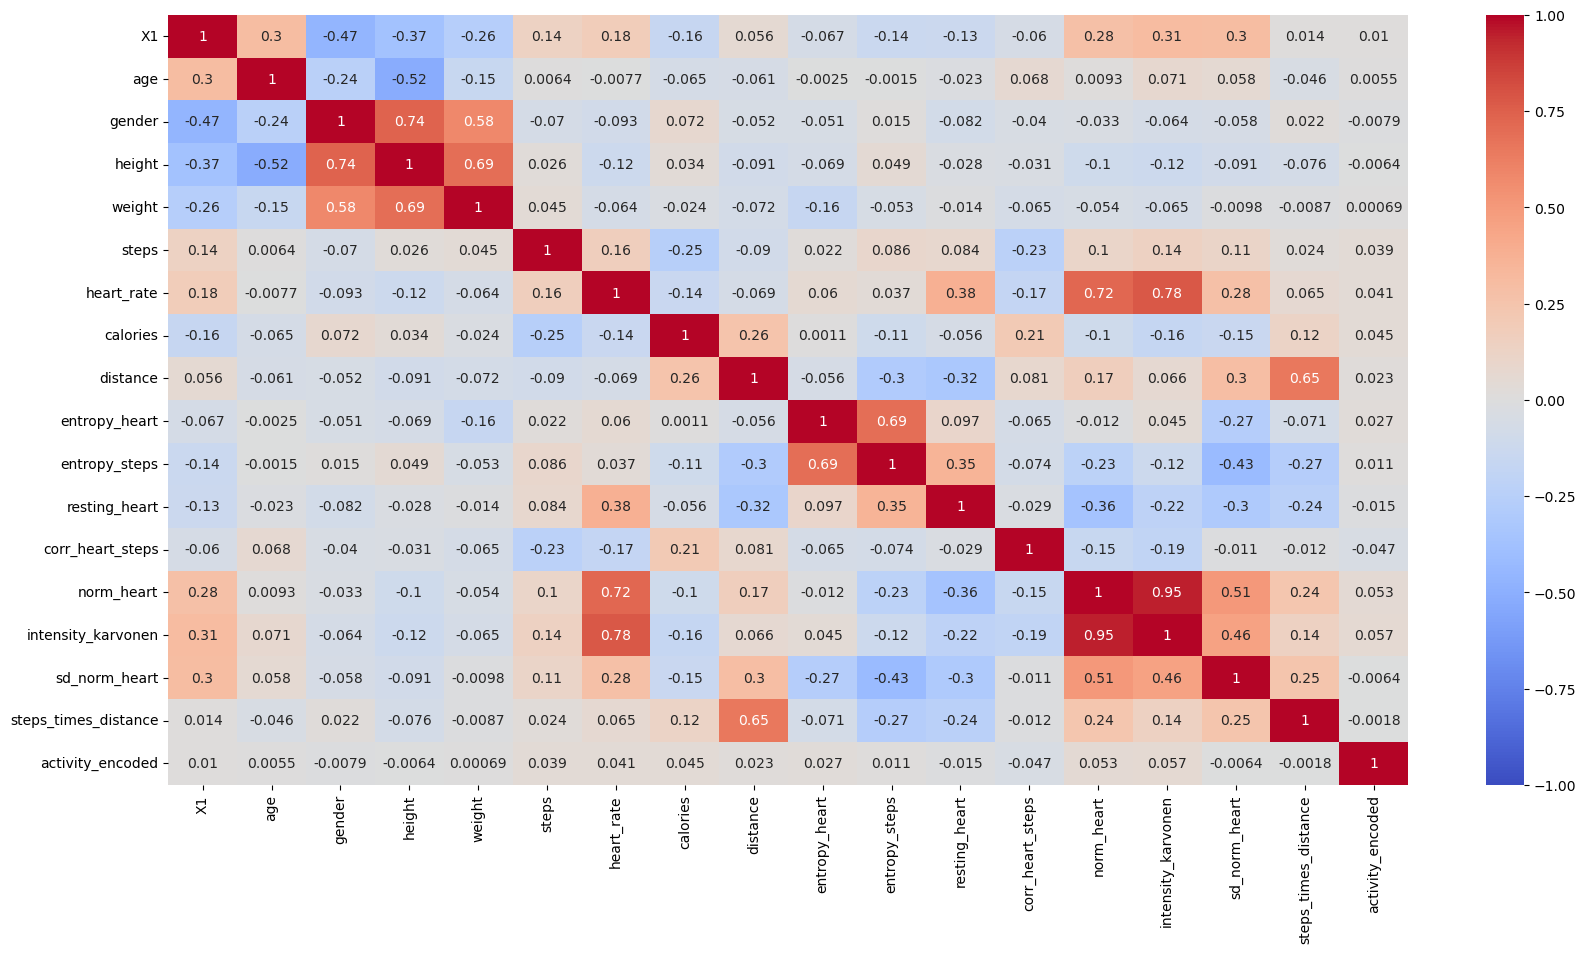

In [25]:
plt.figure(figsize=(20, 10))
sns.heatmap(data_corr,vmin = -1,vmax = 1,annot = True, cmap ='coolwarm')
plt.show()

In [26]:
selected_features = [
    'steps', 'heart_rate', 'calories', 
    'distance', 'entropy_heart', 'entropy_steps',
    'norm_heart', 'intensity_karvonen'
]

<Figure size 2000x1000 with 0 Axes>

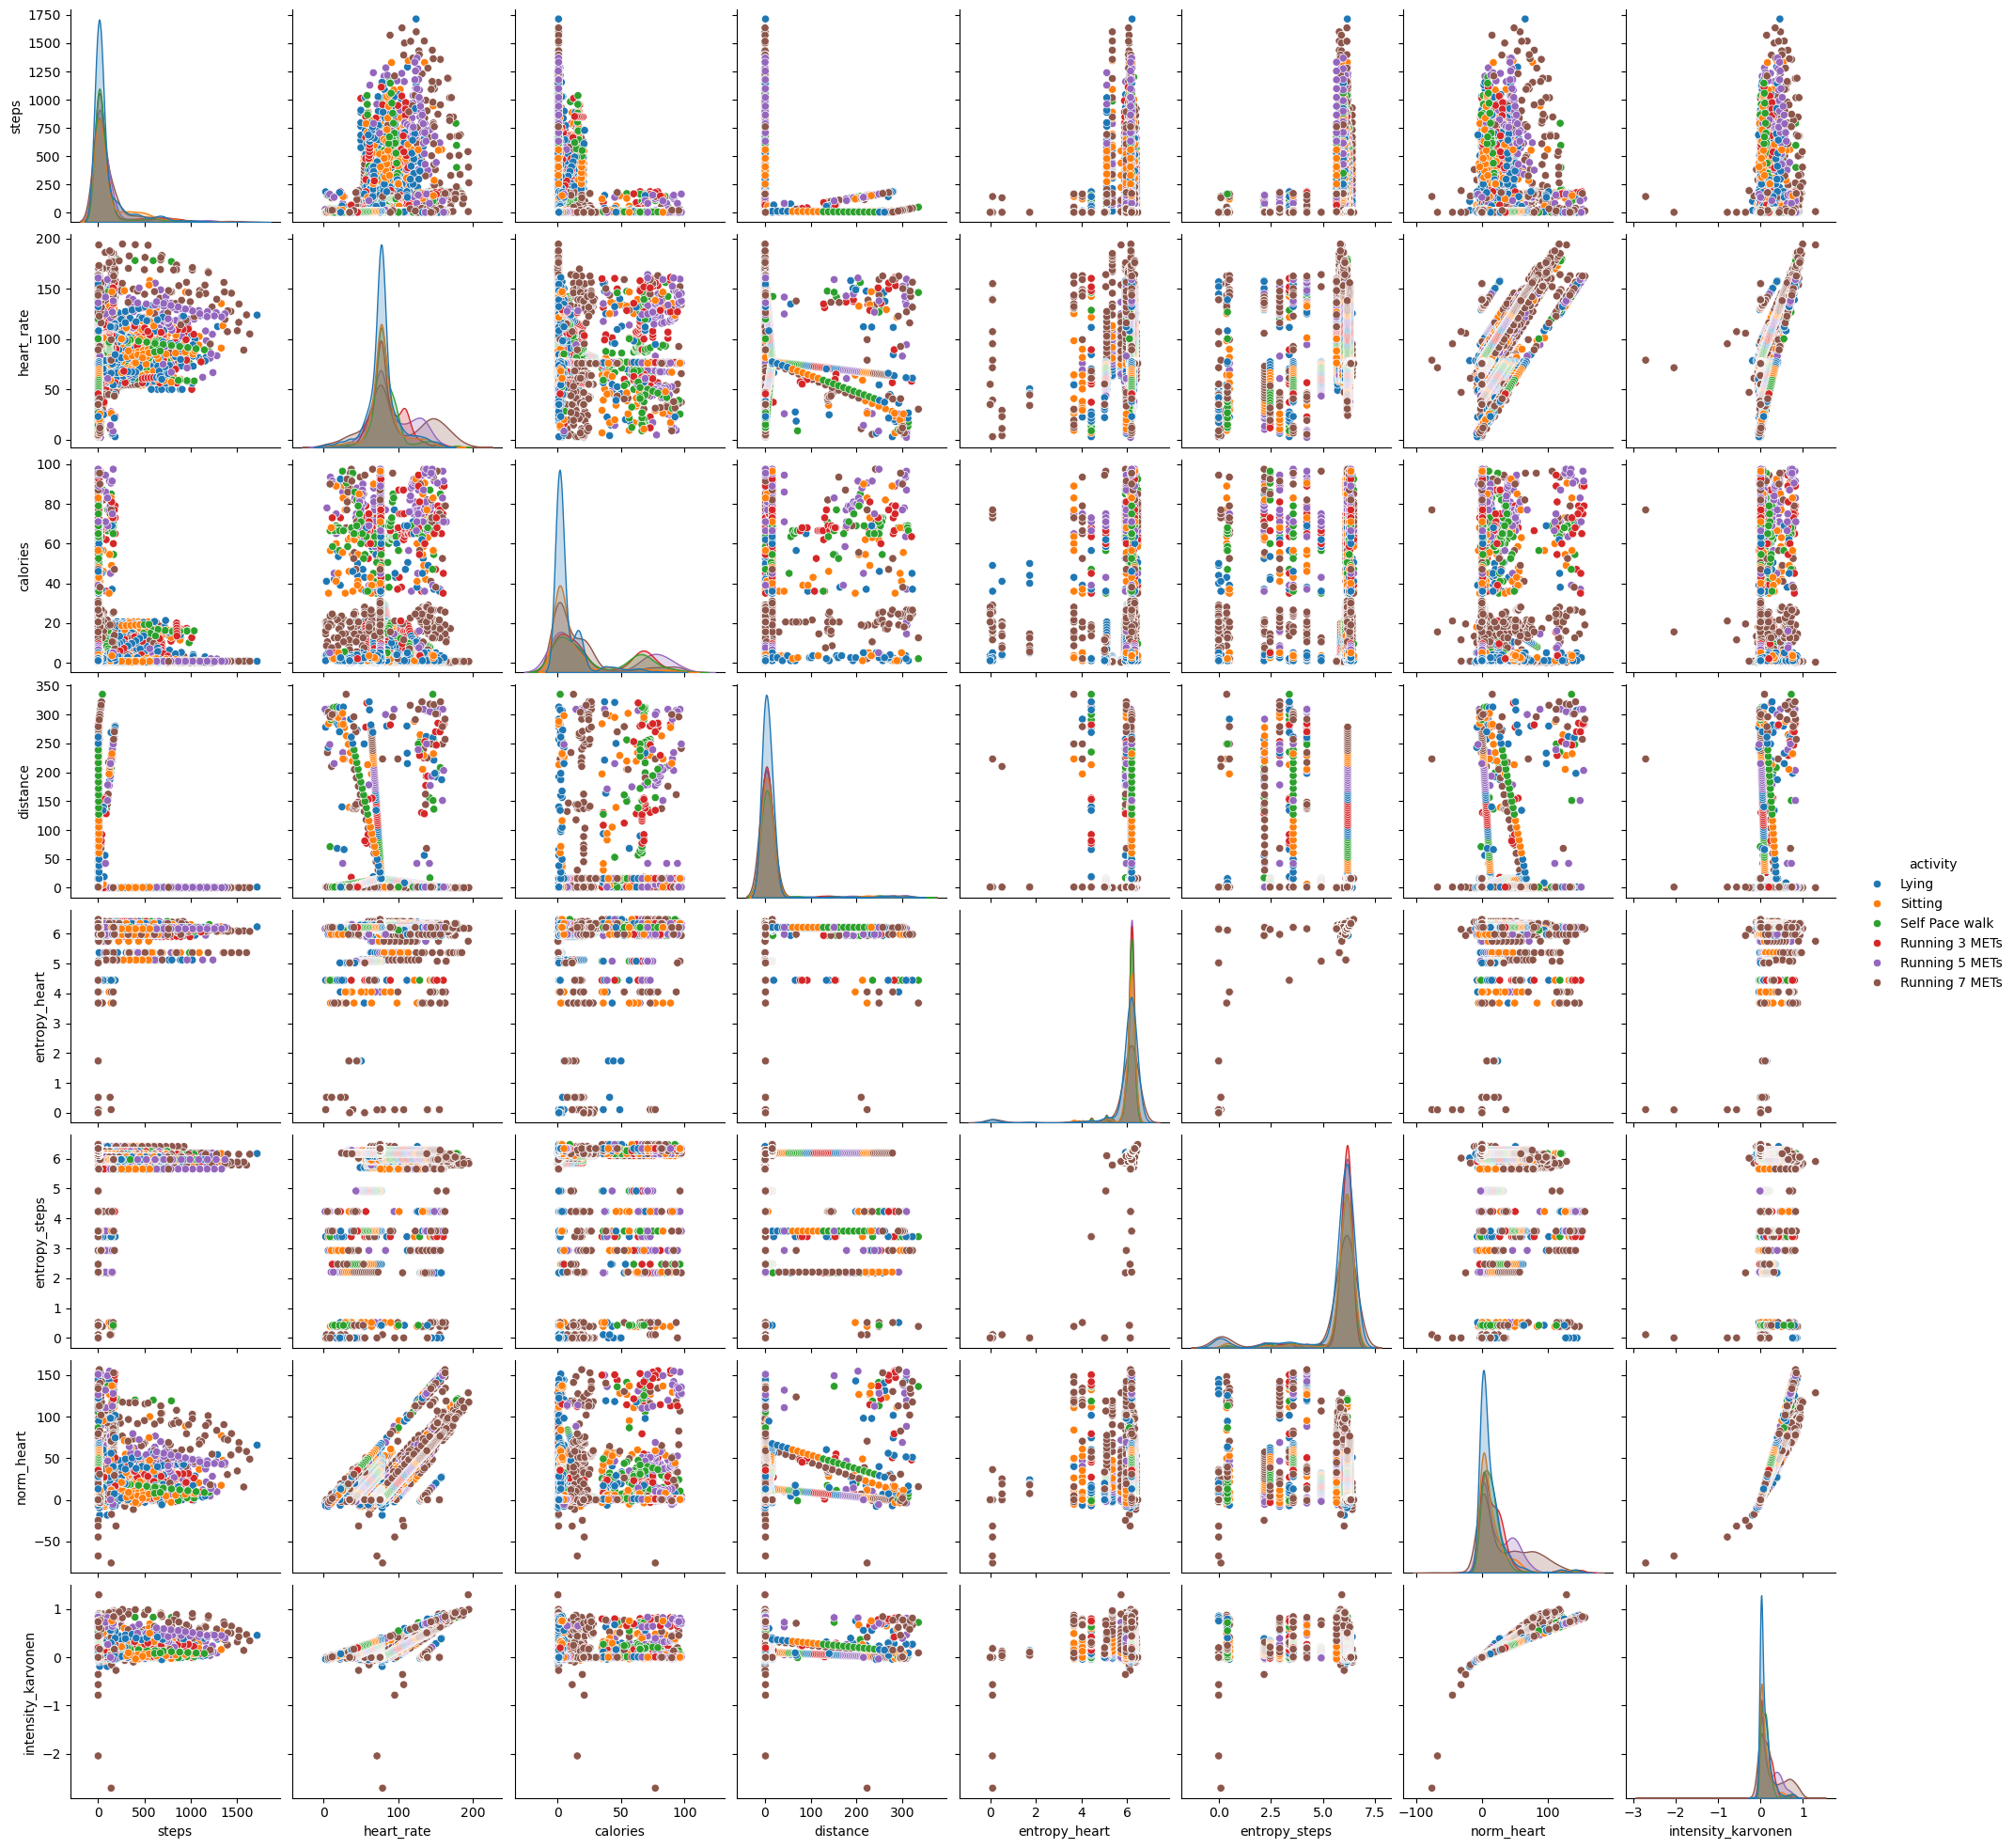

In [27]:
plt.figure(figsize=(20, 10))
sns.pairplot(data, vars=selected_features, hue='activity')
plt.show()

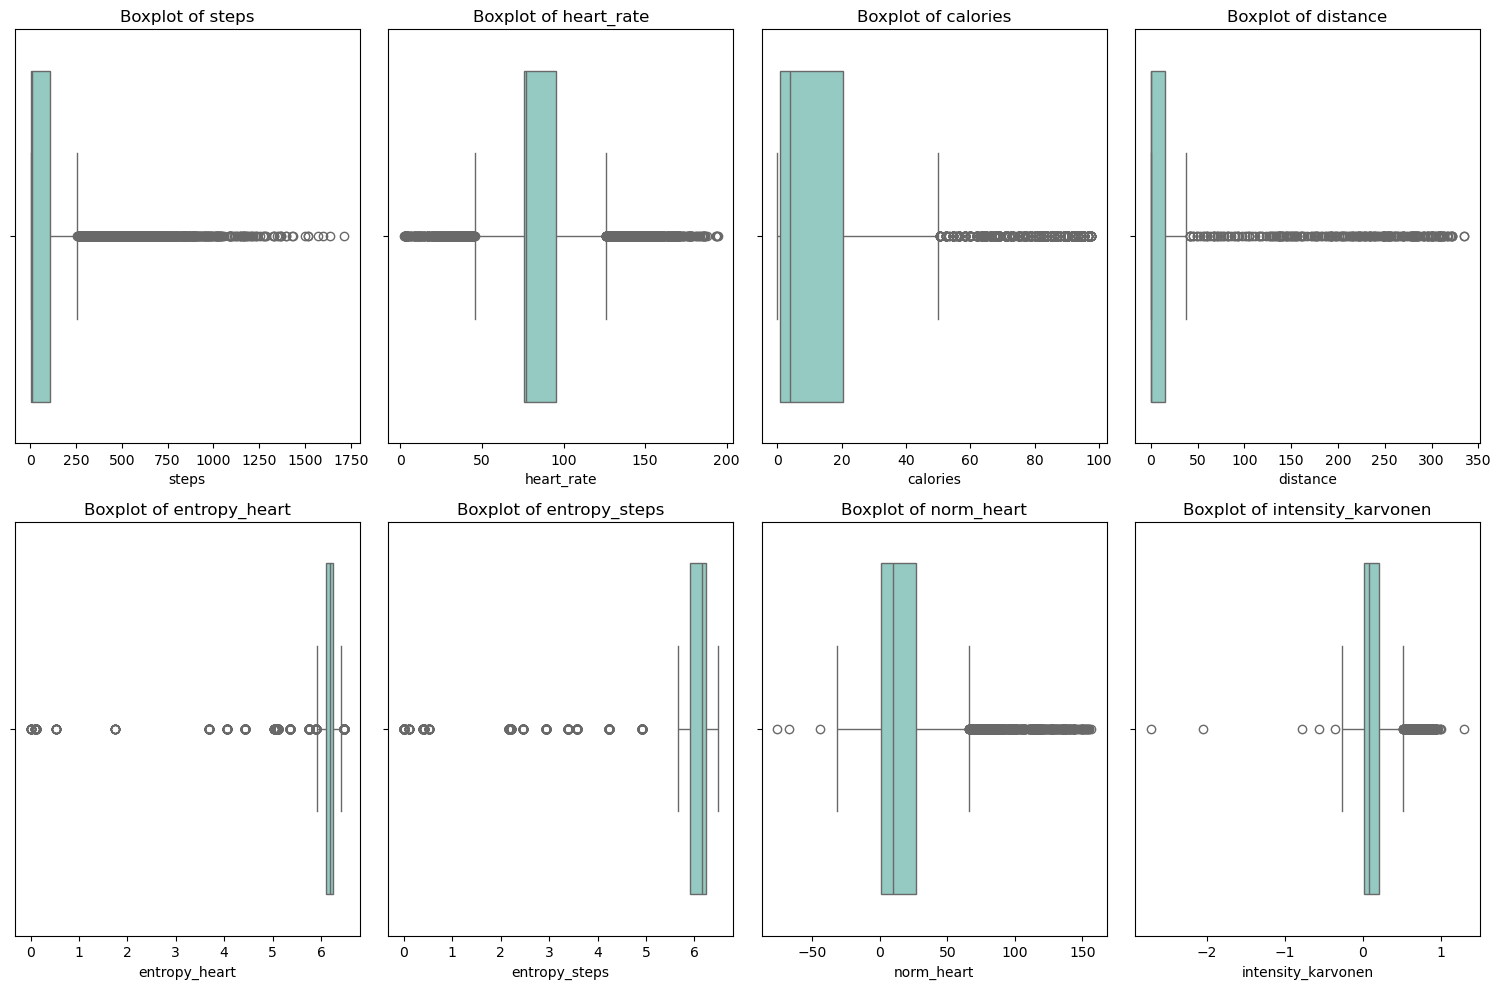

In [28]:
# Plot boxplots for selected features to visualize outliers
plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(data=data[feature], orient='h', color='#8bd3c7')
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

### 3.2. Identifying and removing outliers

#### 3.2.1. Z-score of all numerical features

In [29]:
# Define a threshold for Z-scores
z_threshold = 3

# Compute Z-scores for the selected features
z_scores = data[var].apply(zscore)

# Filter out rows where any of the selected features have Z-scores beyond the threshold
outliers_removed_z_all = data[(np.abs(z_scores) < z_threshold).all(axis=1)]

print(f"Original data shape: {data.shape}")
print(f"Data shape after removing outliers: {outliers_removed_z_all.shape}")
outliers_removed_z_all.head()

Original data shape: (6264, 20)
Data shape after removing outliers: (5239, 20)


X1  age  gender  height  weight      steps  heart_rate   calories  \
1   1   20       1   168.0    65.4  10.771429   78.531302   0.344533   
2   2   20       1   168.0    65.4  11.475325   78.453390   3.287625   
3   3   20       1   168.0    65.4  12.179221   78.540825   9.484000   
4   4   20       1   168.0    65.4  12.883117   78.628260  10.154556   
5   5   20       1   168.0    65.4  13.587013   78.715695  10.825111   

   distance  entropy_heart  entropy_steps  resting_heart  corr_heart_steps  \
1  0.008327       6.221612       6.116349           59.0          1.000000   
2  0.008896       6.221612       6.116349           59.0          1.000000   
3  0.009466       6.221612       6.116349           59.0          1.000000   
4  0.010035       6.221612       6.116349           59.0          1.000000   
5  0.010605       6.221612       6.116349           59.0          0.982816   

   norm_heart  intensity_karvonen  sd_norm_heart  steps_times_distance  \
1   19.531302            0.138520       1.000000              0.089692   
2   19.453390            0.137967       1.000000              0.102088   
3   19.540825            0.138587       1.000000              0.115287   
4   19.628260            0.139208       1.000000              0.129286   
5   19.715695            0.139828       0.241567              0.144088   

        device activity  activity_encoded  
1  apple watch    Lying                 0  
2  apple watch    Lying                 0  
3  apple watch    Lying                 0  
4  apple watch    Lying                 0  
5  apple watch    Lying                 0

#### 3.2.2. Z-score of selected features

In [30]:
# Define a threshold for Z-scores
z_threshold = 3

# Compute Z-scores for the selected features
z_scores = data[selected_features].apply(zscore)

# Filter out rows where any of the selected features have Z-scores beyond the threshold
outliers_removed_z_selected = data[(np.abs(z_scores) < z_threshold).all(axis=1)]

print(f"Original data shape: {data.shape}")
print(f"Data shape after removing outliers: {outliers_removed_z_selected.shape}")
outliers_removed_z_selected.head()

Original data shape: (6264, 20)
Data shape after removing outliers: (5526, 20)


X1  age  gender  height  weight      steps  heart_rate   calories  \
1   1   20       1   168.0    65.4  10.771429   78.531302   0.344533   
2   2   20       1   168.0    65.4  11.475325   78.453390   3.287625   
3   3   20       1   168.0    65.4  12.179221   78.540825   9.484000   
4   4   20       1   168.0    65.4  12.883117   78.628260  10.154556   
5   5   20       1   168.0    65.4  13.587013   78.715695  10.825111   

   distance  entropy_heart  entropy_steps  resting_heart  corr_heart_steps  \
1  0.008327       6.221612       6.116349           59.0          1.000000   
2  0.008896       6.221612       6.116349           59.0          1.000000   
3  0.009466       6.221612       6.116349           59.0          1.000000   
4  0.010035       6.221612       6.116349           59.0          1.000000   
5  0.010605       6.221612       6.116349           59.0          0.982816   

   norm_heart  intensity_karvonen  sd_norm_heart  steps_times_distance  \
1   19.531302            0.138520       1.000000              0.089692   
2   19.453390            0.137967       1.000000              0.102088   
3   19.540825            0.138587       1.000000              0.115287   
4   19.628260            0.139208       1.000000              0.129286   
5   19.715695            0.139828       0.241567              0.144088   

        device activity  activity_encoded  
1  apple watch    Lying                 0  
2  apple watch    Lying                 0  
3  apple watch    Lying                 0  
4  apple watch    Lying                 0  
5  apple watch    Lying                 0

#### 3.2.3. Outliers using IQR method

In [31]:
# Function to remove outliers using IQR method
def remove_outliers_iqr(df, features):
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df

# Remove outliers from the selected features
outliers_removed_iqr = remove_outliers_iqr(data, selected_features)

# Print the shape of the cleaned data
print(f"Original data shape: {data.shape}")
print(f"Data shape after removing outliers: {outliers_removed_iqr.shape}")

Original data shape: (6264, 20)
Data shape after removing outliers: (2723, 20)


### 3.3 Finalising the dataframe for the model development

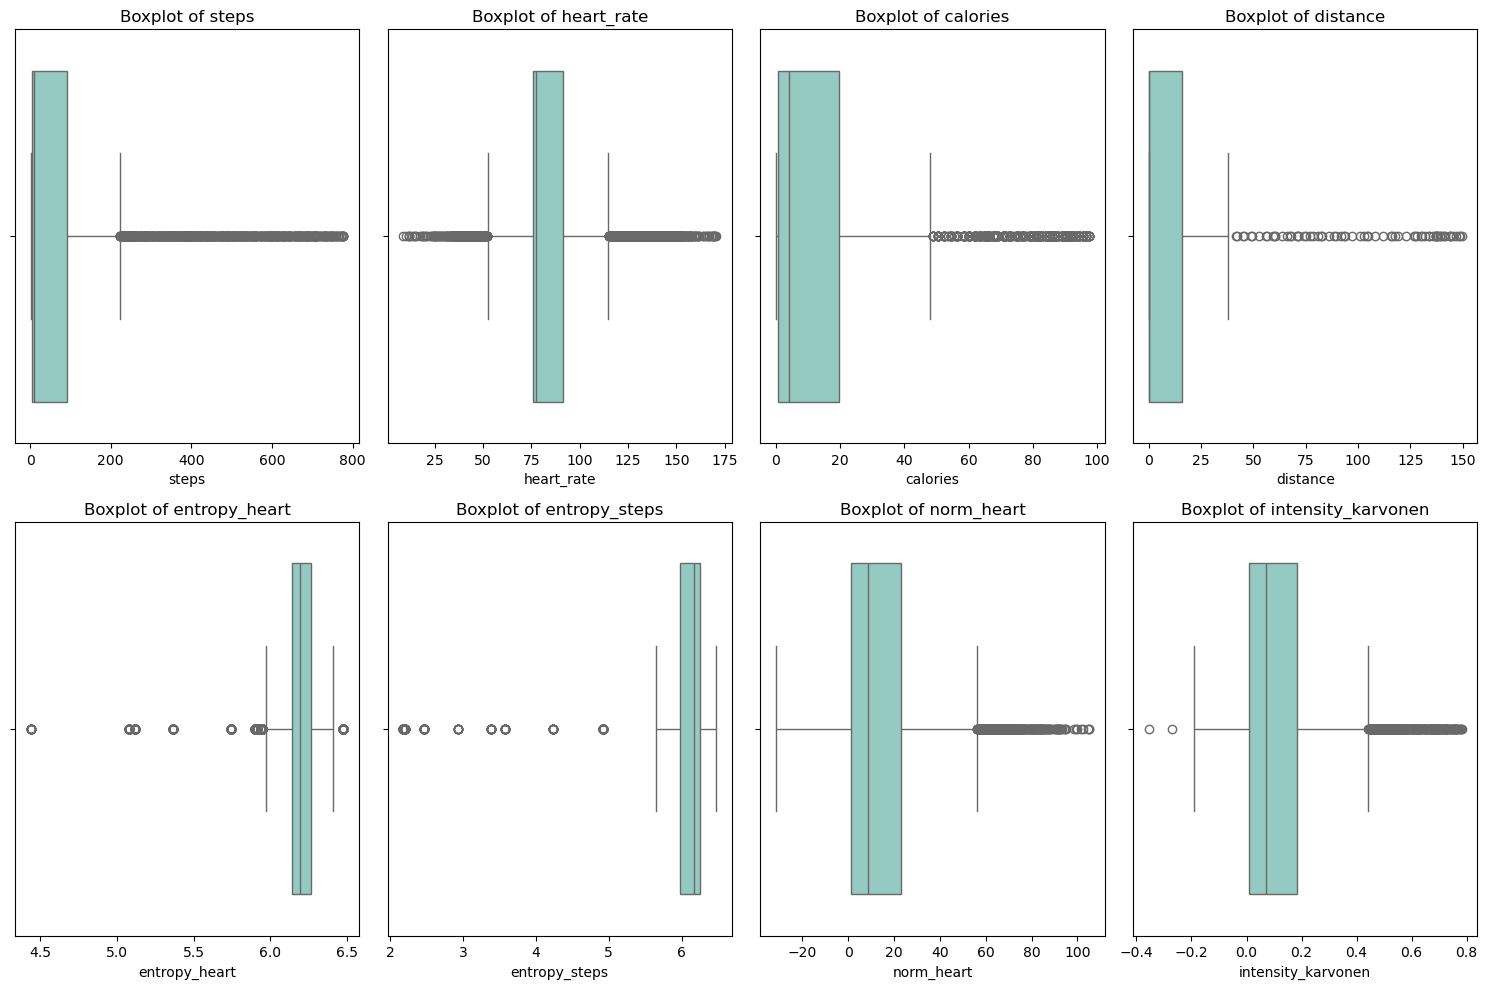

In [32]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(data=outliers_removed_z_selected[feature], orient='h', color='#8bd3c7')
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

In [33]:
class_freq = outliers_removed_z_selected.groupby(['activity']).size()
class_freq

activity
Lying             1237
Running 3 METs     886
Running 5 METs     899
Running 7 METs     843
Self Pace walk     821
Sitting            840
dtype: int64

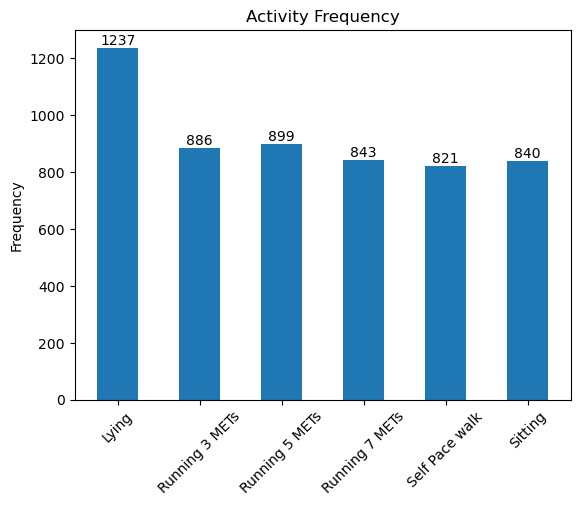

In [34]:
plt.figure()
barplot = plt.bar(class_freq.index, class_freq, width = 0.5)
plt.xlabel(' ')
plt.ylabel('Frequency')
plt.title('Activity Frequency')
plt.bar_label(barplot,labels = class_freq, label_type = "edge")
plt.xticks(rotation=45)
plt.show()

## 4. Modeling and Evaluation

### 4.1. Building DecisionTreeClassifier Model and comparing with all and selected features

In [35]:
X_all = outliers_removed_z_all[var]
y_all = outliers_removed_z_all['activity_encoded']

X_sel = outliers_removed_z_selected[selected_features]
y_sel = outliers_removed_z_selected['activity_encoded']

In [36]:
# Split the data into training and testing sets
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)
X_sel_train, X_sel_test, y_sel_train, y_sel_test = train_test_split(X_sel, y_sel, test_size=0.2, random_state=42)

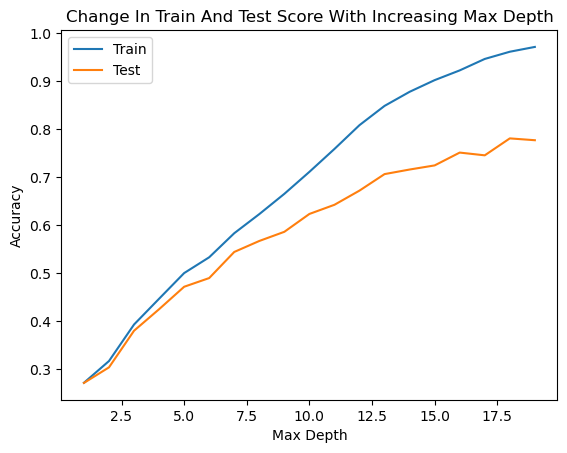

In [37]:
# Define a range of depth values to try
depth_values = range(1, 20)

# Create placeholder lists to append our scores to
train_scores = []
test_scores = []


# Loop through each depth value
for d in depth_values:

    # Create and fit a decision tree with that depth
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_all_train, y_all_train)

    # Calculate train and test accuracies
    train_acc = dt.score(X_all_train, y_all_train)
    test_acc = dt.score(X_all_test, y_all_test)

    # Append them to our lists
    train_scores.append(train_acc)
    test_scores.append(test_acc)


# Let's plot this out

plt.figure()
plt.plot(depth_values, train_scores, label='Train')
plt.plot(depth_values, test_scores, label='Test')
plt.title("Change in train and test score with increasing Max Depth".title())
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Selecting the max depth to be 15, train the model.

In [38]:
# Initialize and train the Decision Tree Classifier
clf_all = DecisionTreeClassifier(random_state=42, max_depth=15)
clf_all.fit(X_all_train, y_all_train)

DecisionTreeClassifier(max_depth=15, random_state=42)

In [39]:
# Initialize and train the Decision Tree Classifier
clf_sel = DecisionTreeClassifier(random_state=42, max_depth=15)
clf_sel.fit(X_sel_train, y_sel_train)

DecisionTreeClassifier(max_depth=15, random_state=42)

In [40]:
# Make predictions on the test set
y_pred_dtc_all = clf_all.predict(X_all_test)

In [41]:
# Make predictions on the test set
y_pred_dtc_sel = clf_sel.predict(X_sel_test)

In [42]:
# Evaluate the model
print("Accuracy Score with all features:", accuracy_score(y_all_test, y_pred_dtc_all))
print("Accuracy Score with selected features:", accuracy_score(y_sel_test, y_pred_dtc_sel))
print("\nClassification Report of all features:\n", classification_report(y_all_test, y_pred_dtc_all))
print("\nClassification Report of selected features:\n", classification_report(y_sel_test, y_pred_dtc_sel))

Accuracy Score with all features: 0.7204198473282443
Accuracy Score with selected features: 0.7233273056057866

Classification Report of all features:
               precision    recall  f1-score   support

           0       0.70      0.69      0.70       224
           1       0.75      0.66      0.70       161
           2       0.80      0.65      0.72       166
           3       0.83      0.82      0.83       163
           4       0.60      0.84      0.70       172
           5       0.73      0.67      0.70       162

    accuracy                           0.72      1048
   macro avg       0.73      0.72      0.72      1048
weighted avg       0.73      0.72      0.72      1048


Classification Report of selected features:
               precision    recall  f1-score   support

           0       0.70      0.67      0.69       259
           1       0.74      0.73      0.74       180
           2       0.78      0.76      0.77       181
           3       0.77      0.81      0.7

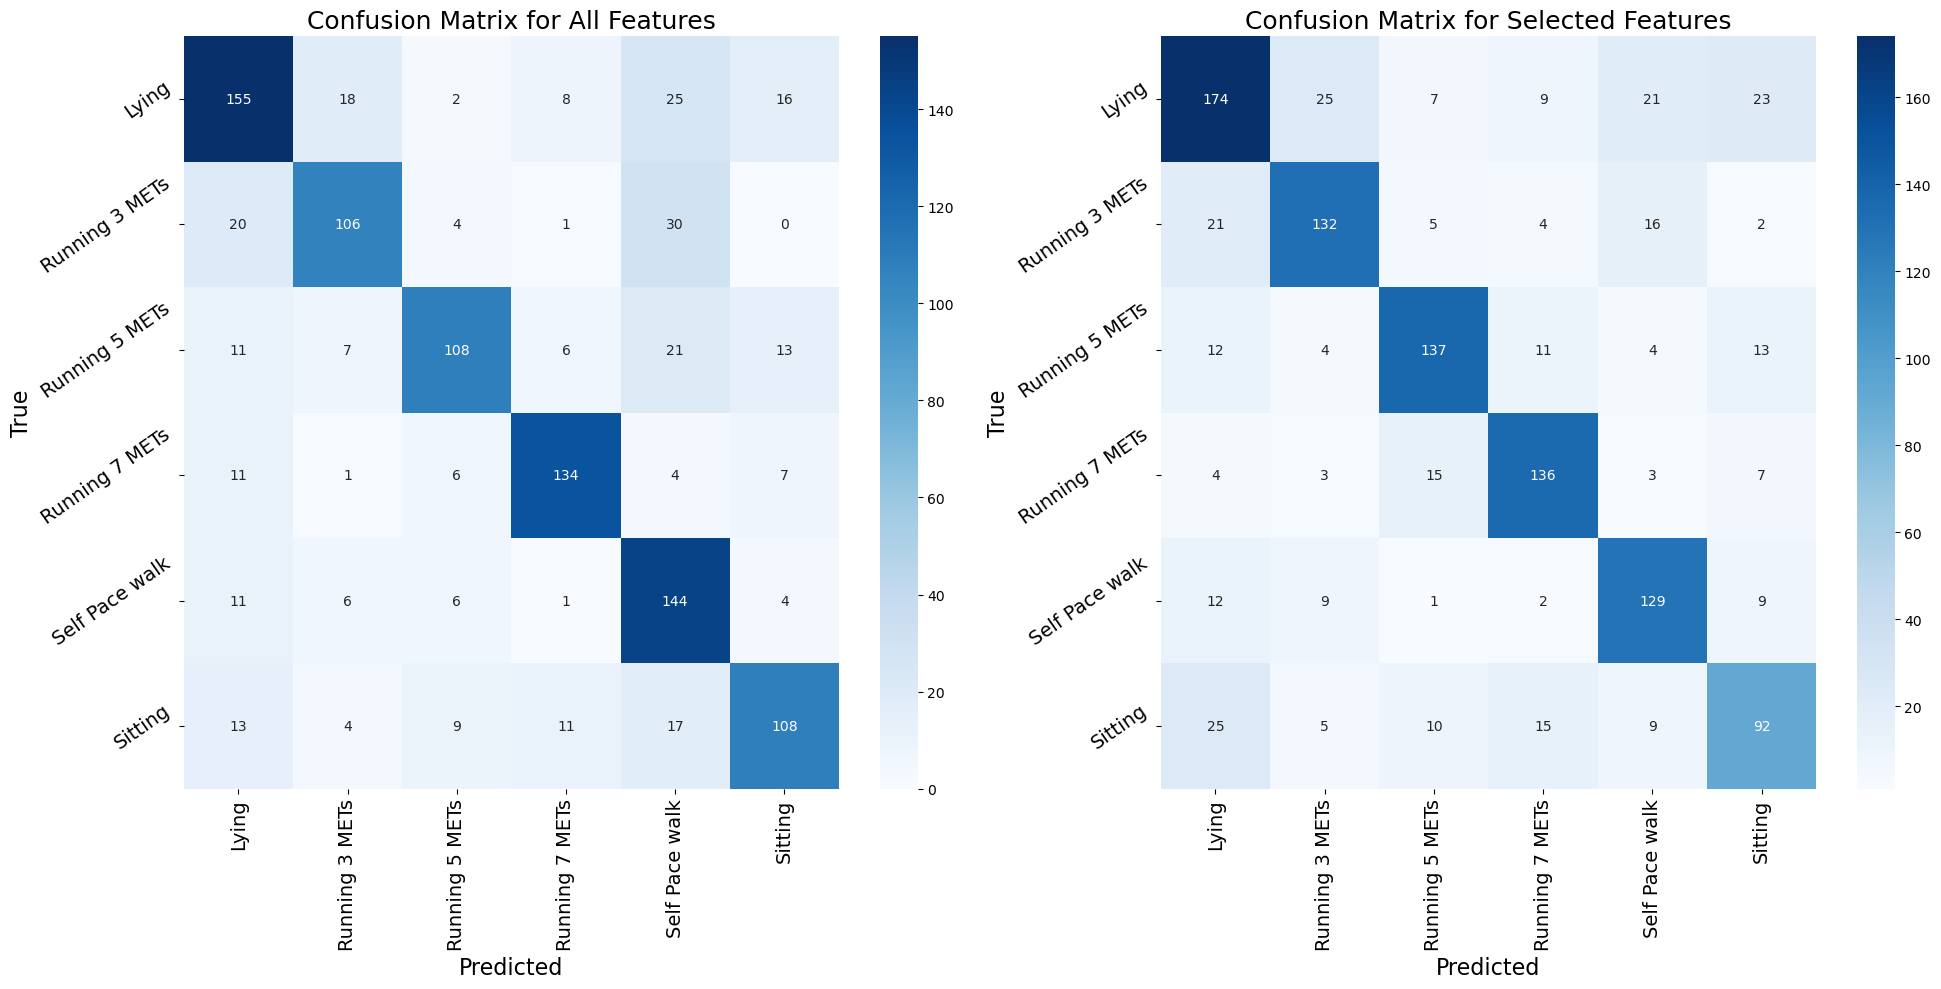

In [43]:
# Generate confusion matrices
conf_matrix_all = confusion_matrix(y_all_test, y_pred_dtc_all, labels=list(le_name_mapping.keys()))
conf_matrix_sel = confusion_matrix(y_sel_test, y_pred_dtc_sel, labels=list(le_name_mapping.keys()))

# Plot the confusion matrices side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

sns.heatmap(conf_matrix_all, annot=True, fmt='d', cmap='Blues', ax=ax1, 
            xticklabels=[le_name_mapping[i] for i in le_name_mapping.keys()], 
            yticklabels=[le_name_mapping[i] for i in le_name_mapping.keys()])
ax1.set_xlabel('Predicted', fontsize=16)
ax1.set_ylabel('True', fontsize=16)
ax1.set_title('Confusion Matrix for All Features', fontsize=18)
ax1.tick_params(axis='x', rotation=90, labelsize=14)
ax1.tick_params(axis='y', rotation=35, labelsize=14)

sns.heatmap(conf_matrix_sel, annot=True, fmt='d', cmap='Blues', ax=ax2, 
            xticklabels=[le_name_mapping[i] for i in le_name_mapping.keys()], 
            yticklabels=[le_name_mapping[i] for i in le_name_mapping.keys()])
ax2.set_xlabel('Predicted', fontsize=16)
ax2.set_ylabel('True', fontsize=16)
ax2.set_title('Confusion Matrix for Selected Features', fontsize=18)
ax2.tick_params(axis='x', rotation=90, labelsize=14)
ax2.tick_params(axis='y', rotation=35, labelsize=14)

plt.tight_layout()
plt.show()

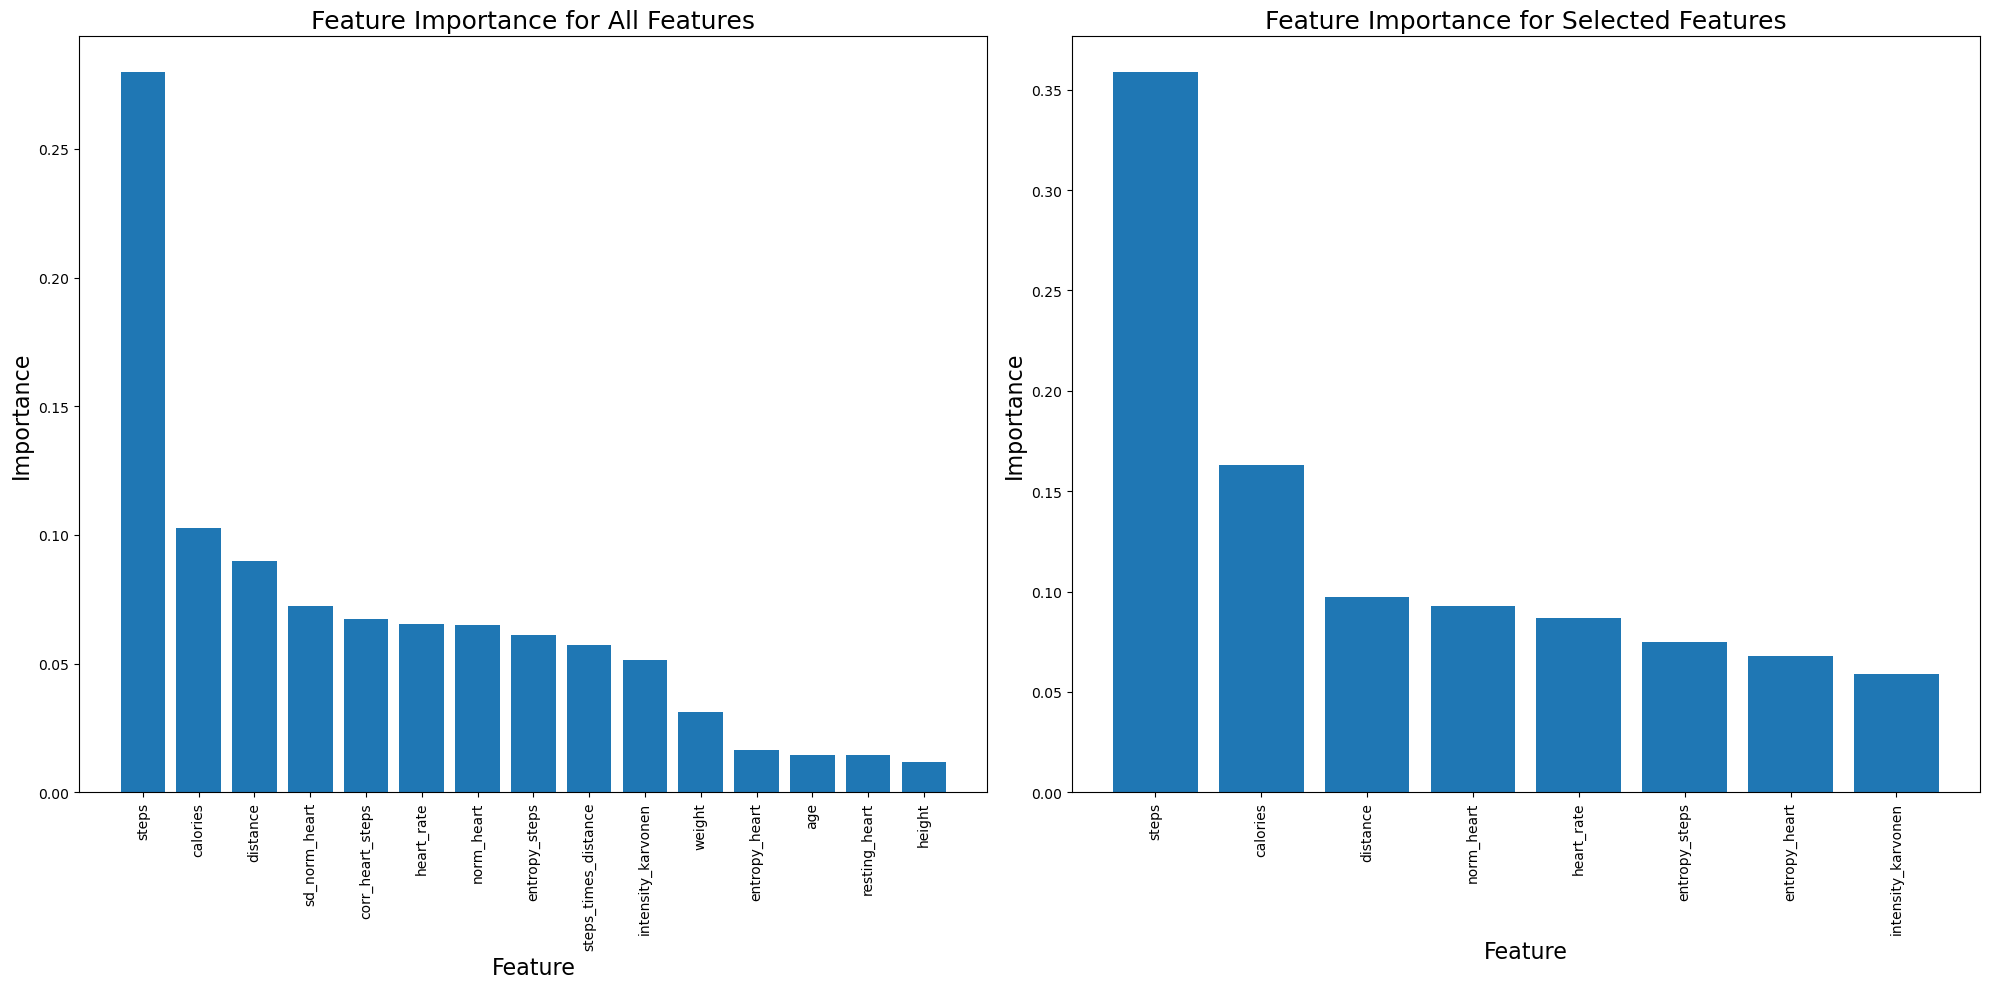

In [44]:
importances_all = clf_all.feature_importances_
importances_sel = clf_sel.feature_importances_

# Sort the importances
indices_all = importances_all.argsort()[::-1]
indices_sel = importances_sel.argsort()[::-1]

# Features
features_all = X_all.columns
features_sel = X_sel.columns

# Plot feature importances side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Feature importance for all features
ax1.bar(range(X_all.shape[1]), importances_all[indices_all], align="center")
ax1.set_xticks(range(X_all.shape[1]))
ax1.set_xticklabels(features_all[indices_all], rotation=90)
ax1.set_xlabel('Feature', fontsize=16)
ax1.set_ylabel('Importance', fontsize=16)
ax1.set_title('Feature Importance for All Features', fontsize=18)

# Feature importance for selected features
ax2.bar(range(X_sel.shape[1]), importances_sel[indices_sel], align="center")
ax2.set_xticks(range(X_sel.shape[1]))
ax2.set_xticklabels(features_sel[indices_sel], rotation=90)
ax2.set_xlabel('Feature', fontsize=16)
ax2.set_ylabel('Importance', fontsize=16)
ax2.set_title('Feature Importance for Selected Features', fontsize=18)

plt.tight_layout()
plt.show()

### 4.2. Building RandomForest with selected features

In [45]:
# Initialize and train the random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_sel_train, y_sel_train)

RandomForestClassifier(random_state=42)

In [46]:
# Make predictions
y_pred_rf = rf.predict(X_sel_test)

In [47]:
print("Accuracy Score:", accuracy_score(y_sel_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_sel_test, y_pred_rf))

Accuracy Score: 0.8318264014466547
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.82      0.81       259
           1       0.88      0.82      0.85       180
           2       0.84      0.84      0.84       181
           3       0.85      0.90      0.88       168
           4       0.86      0.86      0.86       162
           5       0.76      0.75      0.75       156

    accuracy                           0.83      1106
   macro avg       0.83      0.83      0.83      1106
weighted avg       0.83      0.83      0.83      1106



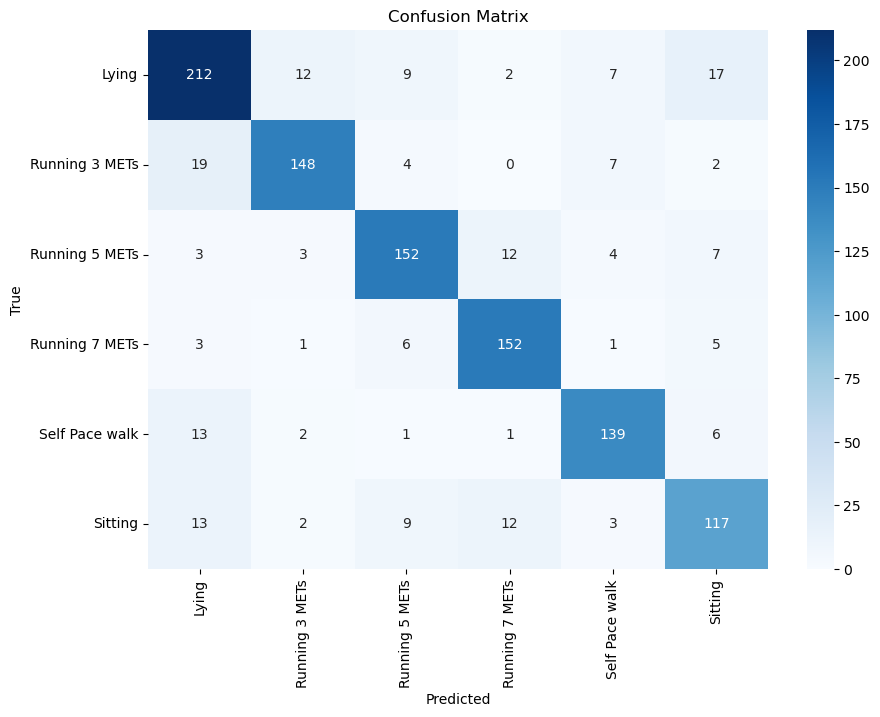

In [48]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_sel_test, y_pred_rf, labels=list(le_name_mapping.keys()))
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[le_name_mapping[i] for i in le_name_mapping.keys()], yticklabels=[le_name_mapping[i] for i in le_name_mapping.keys()])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

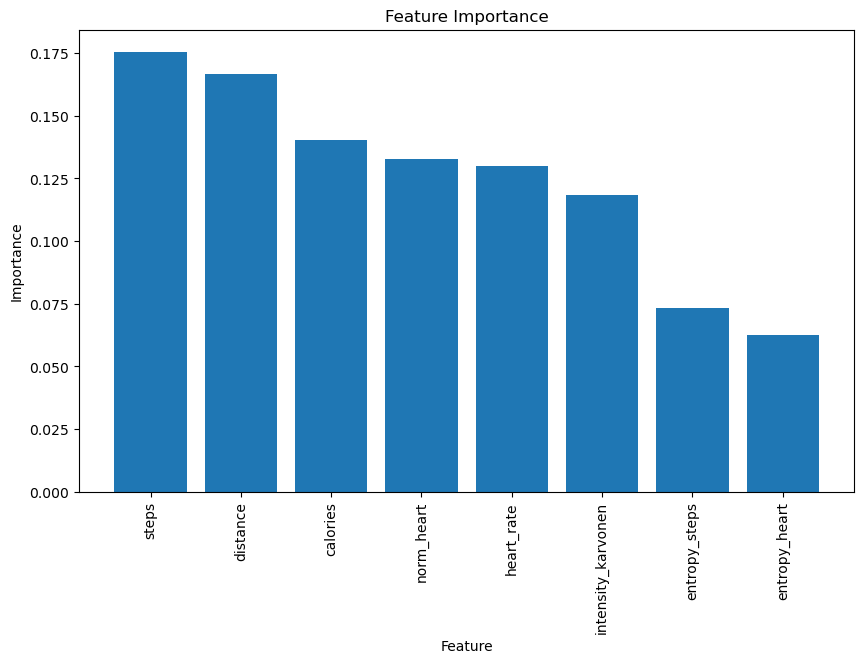

In [49]:
# Plot feature importances
plt.figure(figsize=(10, 6))
features = X_sel.columns
importances = rf.feature_importances_
indices = importances.argsort()[::-1]

plt.bar(range(X_sel.shape[1]), importances[indices], align="center")
plt.xticks(range(X_sel.shape[1]), features[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

In [50]:
# Apply SMOTE to the training data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_sel_train, y_sel_train)

In [51]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train_res)
X_test_sc = sc.transform(X_sel_test)

In [52]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [53]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

In [54]:
# Perform the grid search
grid_search.fit(X_train_sc, y_train_res)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [55]:
# Print the best parameters and the corresponding score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

Best parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.8500340831629175


In [56]:
# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_pred_rf_gsc = best_model.predict(X_test_sc)

In [57]:
print("Accuracy Score:", accuracy_score(y_sel_test, y_pred_rf_gsc))
print('Classification tree report \n',classification_report(y_sel_test, y_pred_rf_gsc))

Accuracy Score: 0.8354430379746836
Classification tree report 
               precision    recall  f1-score   support

           0       0.82      0.79      0.80       259
           1       0.87      0.84      0.86       180
           2       0.85      0.88      0.86       181
           3       0.88      0.89      0.88       168
           4       0.85      0.86      0.86       162
           5       0.74      0.78      0.76       156

    accuracy                           0.84      1106
   macro avg       0.84      0.84      0.84      1106
weighted avg       0.84      0.84      0.84      1106



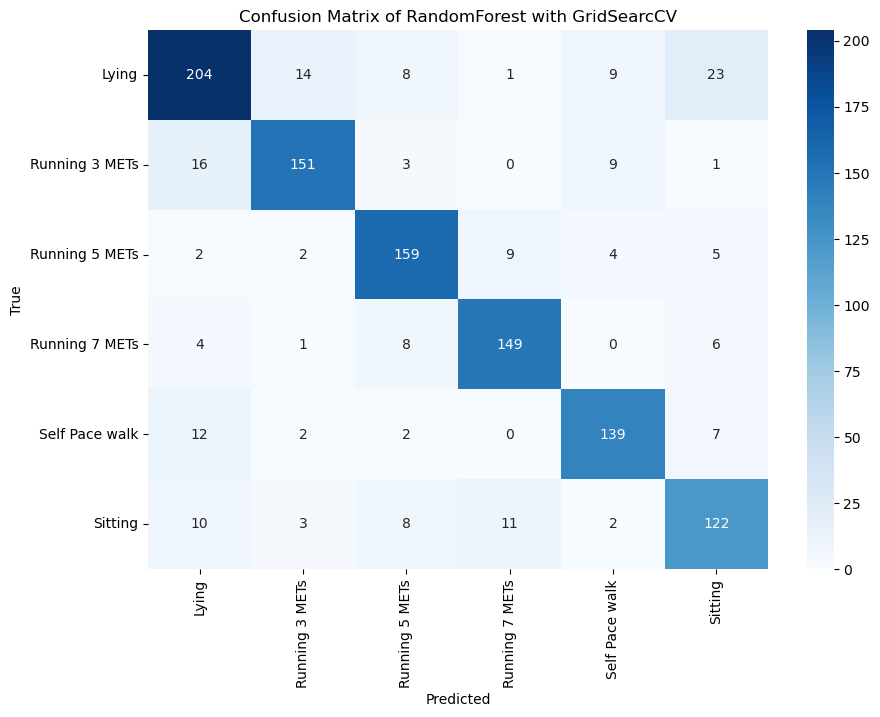

In [58]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_sel_test, y_pred_rf_gsc, labels=list(le_name_mapping.keys()))
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[le_name_mapping[i] for i in le_name_mapping.keys()], yticklabels=[le_name_mapping[i] for i in le_name_mapping.keys()])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of RandomForest with GridSearcCV')
plt.show()

### 4.3. Building XGBoost Model with selected features

In [59]:
# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Define parameter distributions
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

In [60]:
# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(y_sel.unique()), random_state=42)


In [62]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=50, cv=3, scoring='accuracy', verbose=2, n_jobs=-1, random_state=42)

# Perform the grid search
grid_search.fit(X_train_sc, y_train_res)
# Perform the random search
random_search.fit(X_train_sc, y_train_res)

# Print the best parameters and the corresponding score
print(f"Best parameters of grid search: {grid_search.best_params_}")
print(f"Best cross-validation accuracy of grid search: {grid_search.best_score_}")

# Print the best parameters and the corresponding score
print(f"Best parameters of random search: {random_search.best_params_}")
print(f"Best cross-validation accuracy of random search: {random_search.best_score_}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters of grid search: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Best cross-validation accuracy of grid search: 0.8428766189502386
Best parameters of random search: {'colsample_bytree': 0.8493192507310232, 'learning_rate': 0.07617960497052984, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.8675365010654429}
Best cross-validation accuracy of random search: 0.8456032719836402


In [63]:
# Make predictions
#y_pred_xgb = xgb_model.predict(X_test_sc)

# Use the best model to make predictions
best_model_gs = grid_search.best_estimator_
y_pred_xgb_gs = best_model_gs.predict(X_test_sc)

# Use the best model to make predictions
best_model_rs = random_search.best_estimator_
y_pred_xgb_rs = best_model_rs.predict(X_test_sc)

In [64]:
print("Accuracy Score with gridSearchCV:", accuracy_score(y_sel_test, y_pred_xgb_gs))
print('Classification report with gridSearchCV\n',classification_report(y_sel_test, y_pred_xgb_gs))

print("Accuracy Score with RandomizedSearchCV:", accuracy_score(y_sel_test, y_pred_xgb_rs))
print('Classification report with RandomizedSearchCV \n',classification_report(y_sel_test, y_pred_xgb_rs))

Accuracy Score with gridSearchCV: 0.8471971066907775
Classification report with gridSearchCV
               precision    recall  f1-score   support

           0       0.84      0.80      0.82       259
           1       0.89      0.85      0.87       180
           2       0.87      0.88      0.88       181
           3       0.88      0.89      0.88       168
           4       0.87      0.89      0.88       162
           5       0.73      0.78      0.76       156

    accuracy                           0.85      1106
   macro avg       0.85      0.85      0.85      1106
weighted avg       0.85      0.85      0.85      1106

Accuracy Score with RandomizedSearchCV: 0.8417721518987342
Classification report with RandomizedSearchCV 
               precision    recall  f1-score   support

           0       0.82      0.79      0.80       259
           1       0.89      0.83      0.86       180
           2       0.88      0.88      0.88       181
           3       0.89      0.90      

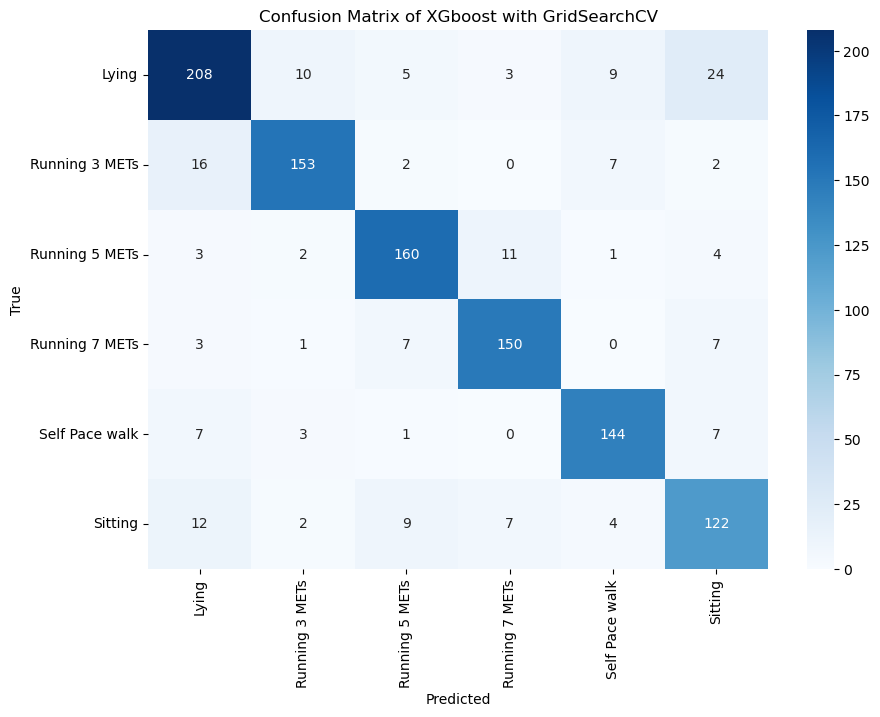

In [65]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_sel_test, y_pred_xgb_gs, labels=list(le_name_mapping.keys()))
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[le_name_mapping[i] for i in le_name_mapping.keys()], yticklabels=[le_name_mapping[i] for i in le_name_mapping.keys()])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of XGboost with GridSearchCV')
plt.show()

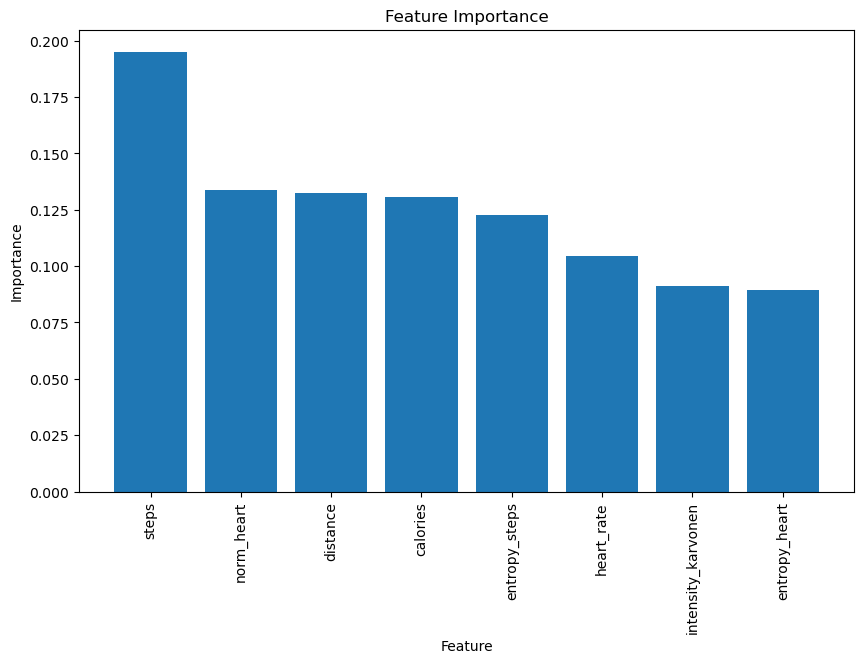

In [66]:
# Plot feature importances
plt.figure(figsize=(10, 6))
features = X_sel.columns
importances = best_model_gs.feature_importances_
indices = importances.argsort()[::-1]

plt.bar(range(X_sel.shape[1]), importances[indices], align="center")
plt.xticks(range(X_sel.shape[1]), features[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

In [67]:
# Initialize the VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('rf', best_model),
    ('xgb', best_model_gs)
], voting='soft')

In [68]:
# Train the ensemble model
voting_clf.fit(X_train_sc, y_train_res)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     max_features='auto',
                                                     n_estimators=300,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1.0, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_t...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.2, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_class=6, num_parallel_tree=None, ...))],
                 voting='soft')

In [69]:
# Make predictions
y_pred_vot = voting_clf.predict(X_test_sc)

In [70]:
# Evaluate the model
print("Accuracy Score:", accuracy_score(y_sel_test, y_pred_vot))
print('Classification tree report \n',classification_report(y_sel_test, y_pred_vot))

Accuracy Score: 0.8544303797468354
Classification tree report 
               precision    recall  f1-score   support

           0       0.84      0.82      0.83       259
           1       0.90      0.85      0.87       180
           2       0.87      0.88      0.88       181
           3       0.88      0.91      0.90       168
           4       0.89      0.89      0.89       162
           5       0.75      0.79      0.77       156

    accuracy                           0.85      1106
   macro avg       0.86      0.86      0.86      1106
weighted avg       0.86      0.85      0.85      1106



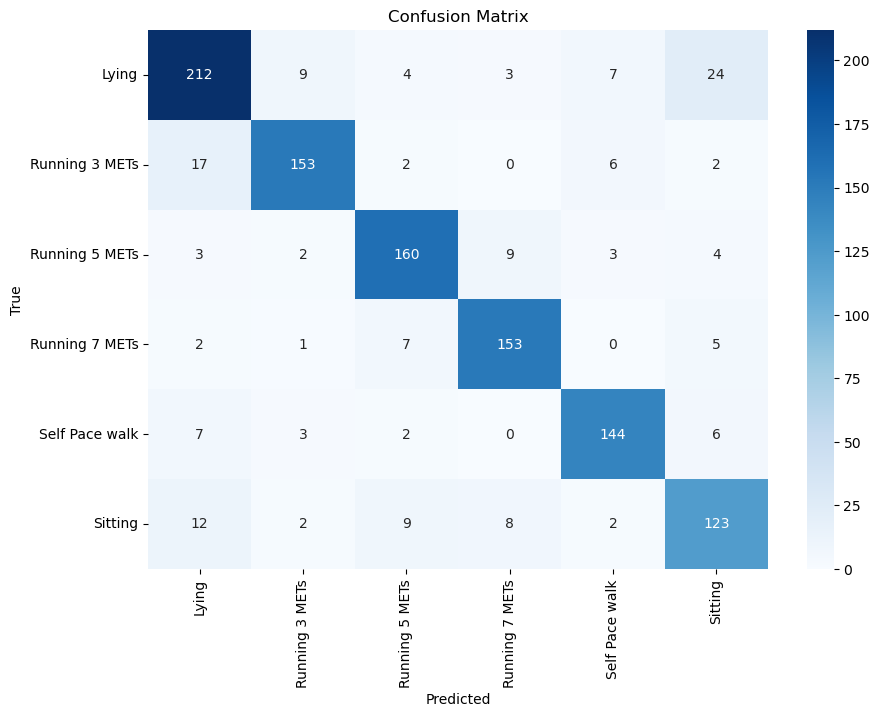

In [71]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_sel_test, y_pred_vot, labels=list(le_name_mapping.keys()))
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[le_name_mapping[i] for i in le_name_mapping.keys()], yticklabels=[le_name_mapping[i] for i in le_name_mapping.keys()])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 5. Feature Engineering

In [72]:
# Step Distance Ratio
outliers_removed_z_selected['step_distance_ratio'] = outliers_removed_z_selected['steps'] / outliers_removed_z_selected['distance']

# Calories per Step
outliers_removed_z_selected['calories_per_step'] = outliers_removed_z_selected['calories'] / outliers_removed_z_selected['steps']

outliers_removed_z_selected.head()

C:\Users\shriy\AppData\Local\Temp\ipykernel_10552\3869643634.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\shriy\AppData\Local\Temp\ipykernel_10552\3869643634.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



X1  age  gender  height  weight      steps  heart_rate   calories  \
1   1   20       1   168.0    65.4  10.771429   78.531302   0.344533   
2   2   20       1   168.0    65.4  11.475325   78.453390   3.287625   
3   3   20       1   168.0    65.4  12.179221   78.540825   9.484000   
4   4   20       1   168.0    65.4  12.883117   78.628260  10.154556   
5   5   20       1   168.0    65.4  13.587013   78.715695  10.825111   

   distance  entropy_heart  ...  corr_heart_steps  norm_heart  \
1  0.008327       6.221612  ...          1.000000   19.531302   
2  0.008896       6.221612  ...          1.000000   19.453390   
3  0.009466       6.221612  ...          1.000000   19.540825   
4  0.010035       6.221612  ...          1.000000   19.628260   
5  0.010605       6.221612  ...          0.982816   19.715695   

   intensity_karvonen  sd_norm_heart  steps_times_distance       device  \
1            0.138520       1.000000              0.089692  apple watch   
2            0.137967       1.000000              0.102088  apple watch   
3            0.138587       1.000000              0.115287  apple watch   
4            0.139208       1.000000              0.129286  apple watch   
5            0.139828       0.241567              0.144088  apple watch   

   activity activity_encoded step_distance_ratio  calories_per_step  
1     Lying                0         1293.576722           0.031986  
2     Lying                0         1289.891857           0.286495  
3     Lying                0         1286.650374           0.778703  
4     Lying                0         1283.776788           0.788206  
5     Lying                0         1281.211832           0.796725  

[5 rows x 22 columns]

In [73]:
feature_eng = [
    'steps', 'heart_rate', 'calories', 
    'distance', 'entropy_heart', 'entropy_steps',
    'norm_heart', 'intensity_karvonen', 'step_distance_ratio', 'calories_per_step'
]

In [74]:
X_fet = outliers_removed_z_selected[feature_eng]
y_fet = outliers_removed_z_selected['activity_encoded']

In [75]:
X_fet_train, X_fet_test, y_fet_train, y_fet_test = train_test_split(X_fet, y_fet, test_size=0.2, random_state=42)

In [78]:
#SMOTE
X_train_sm, y_train_sm = sm.fit_resample(X_fet_train, y_fet_train)

In [79]:
#Scaling
X_train_scale = sc.fit_transform(X_train_sm)
X_test_scale = sc.transform(X_fet_test)

In [80]:
# Perform the grid search
grid_search.fit(X_train_scale, y_train_sm)
# Perform the random search

# Print the best parameters and the corresponding score
print(f"Best parameters of grid search: {grid_search.best_params_}")
print(f"Best cross-validation accuracy of grid search: {grid_search.best_score_}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters of grid search: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Best cross-validation accuracy of grid search: 0.8483299250170416


In [81]:
# Use the best model to make predictions
best_model_fet = grid_search.best_estimator_
y_pred_xgb_fet = best_model_fet.predict(X_test_scale)

In [82]:
print("Accuracy Score with gridSearchCV:", accuracy_score(y_fet_test, y_pred_xgb_fet))
print('Classification report with gridSearchCV\n',classification_report(y_fet_test, y_pred_xgb_fet))

Accuracy Score with gridSearchCV: 0.8616636528028933
Classification report with gridSearchCV
               precision    recall  f1-score   support

           0       0.85      0.83      0.84       259
           1       0.91      0.85      0.88       180
           2       0.89      0.88      0.89       181
           3       0.89      0.91      0.90       168
           4       0.87      0.90      0.88       162
           5       0.77      0.81      0.79       156

    accuracy                           0.86      1106
   macro avg       0.86      0.86      0.86      1106
weighted avg       0.86      0.86      0.86      1106



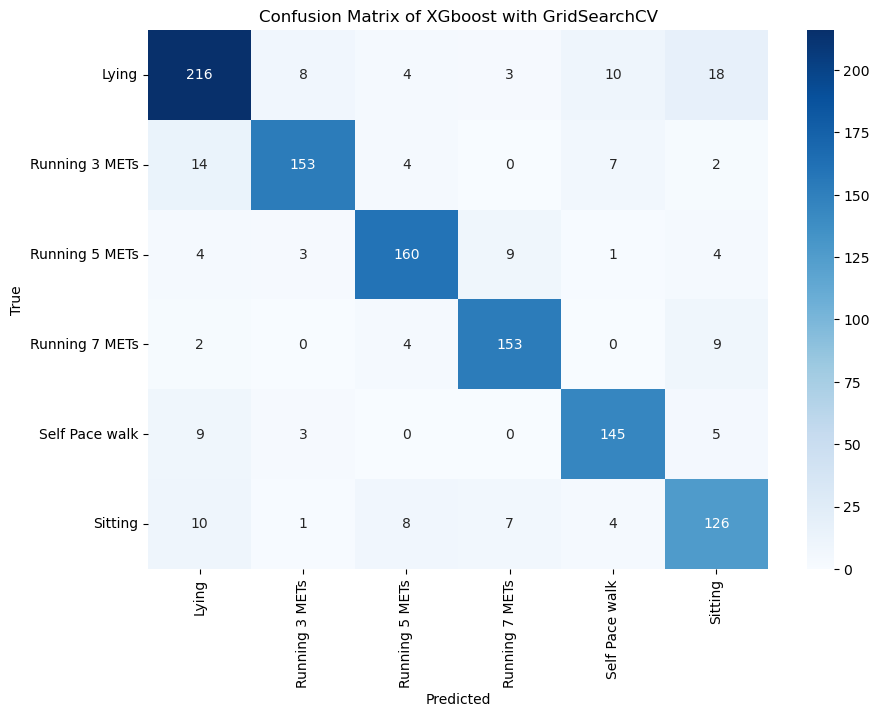

In [83]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_fet_test, y_pred_xgb_fet, labels=list(le_name_mapping.keys()))
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[le_name_mapping[i] for i in le_name_mapping.keys()], yticklabels=[le_name_mapping[i] for i in le_name_mapping.keys()])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of XGboost with GridSearchCV')
plt.show()

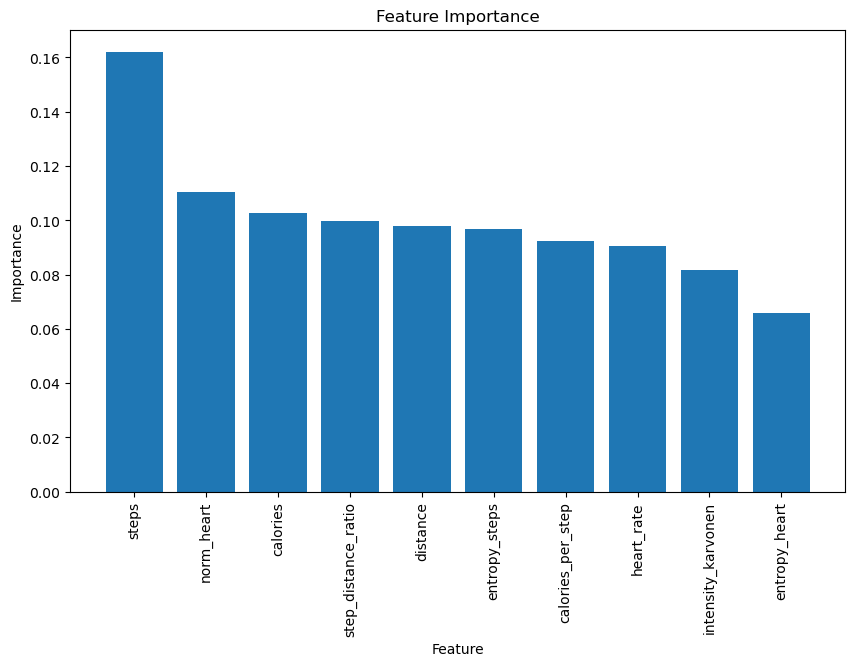

In [86]:
# Plot feature importances
plt.figure(figsize=(10, 6))
features = X_fet.columns
importances = best_model_fet.feature_importances_
indices = importances.argsort()[::-1]

plt.bar(range(X_fet.shape[1]), importances[indices], align="center")
plt.xticks(range(X_fet.shape[1]), features[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()